# **Group Assignment** - Bike Sharing

- `instant`: record index
- `dteday` : date
- `season` : season (1:spring, 2:summer, 3:fall, 4:winter)
- `yr` : year (0: 2011, 1:2012)
- `mnth` : month ( 1 to 12)
- `hr` : hour (0 to 23)
- `holiday` : wether day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- `weekday` : day of the week
- `workingday` : if day is neither weekend nor holiday is 1, otherwise is 0.
+ `weathersit` : 
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- `temp` : Normalized temperature in Celsius. The values are divided to 41 (max)
- `atemp`: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- `hum`: Normalized humidity. The values are divided to 100 (max)
- `windspeed`: Normalized wind speed. The values are divided to 67 (max)
- `casual`: count of casual users
- `registered`: count of registered users
- `cnt`: count of total rental bikes including both casual and registered

## PART I: Exploratory Data Analysis

In [515]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import joblib
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor

In [516]:
data = pd.read_csv("data/hour.csv")

In [517]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


non-null count for each column is equal to the RangeIndex -> no null values

In [518]:
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## De-normalising the data

We de-normalize the data to make the input more user friendly

In [519]:
data['temp'] = data['temp'] * 41
data['hum'] = data['hum'] * 100
data['windspeed'] = data['windspeed'] * 67
data['atemp'] = data['atemp'] * 50

## Distribution of Target variable (count of bikes)

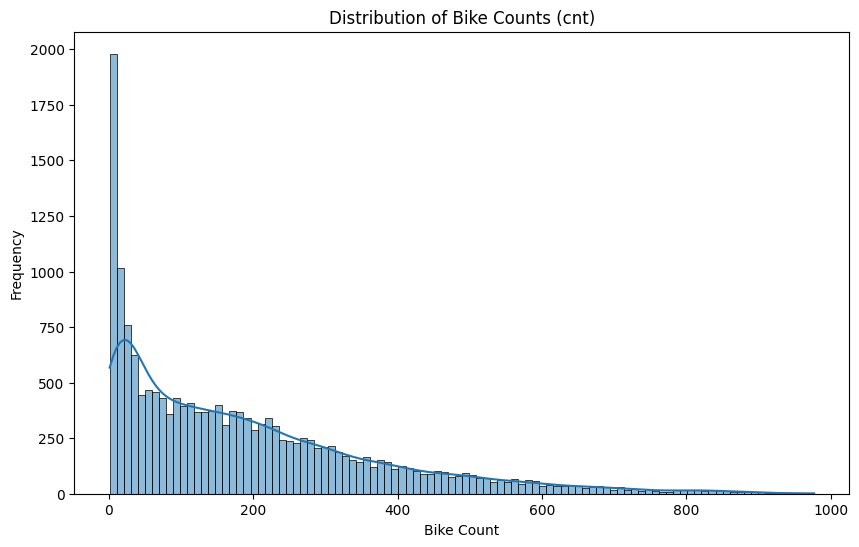

In [520]:
plt.figure(figsize=(10, 6))
sns.histplot(data['cnt'], bins=100, kde=True)
plt.title('Distribution of Bike Counts (cnt)')
plt.xlabel('Bike Count')
plt.ylabel('Frequency')
plt.show()

Large spike for lower counts, we will have to further investigate to see if there is a pattern causing these low count values

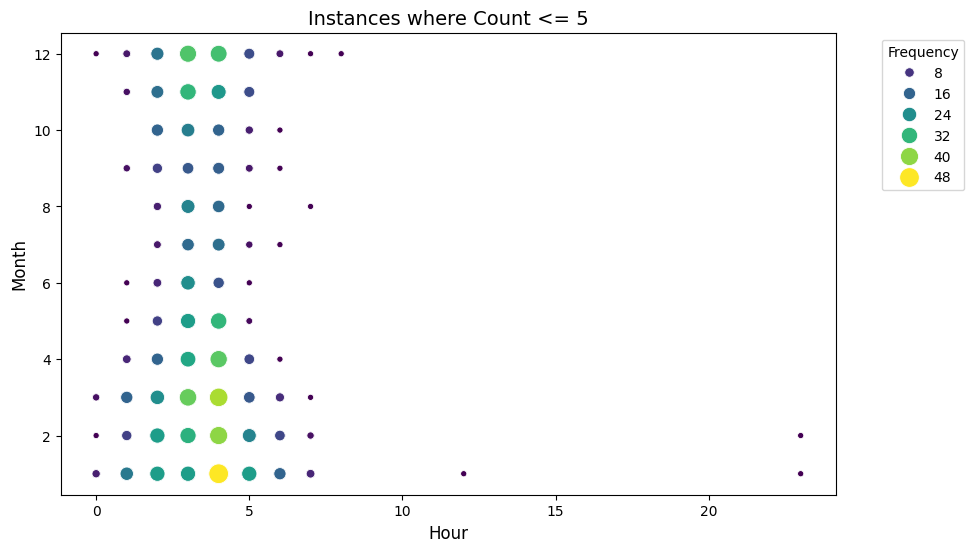

In [521]:
filtered_data = data[data['cnt'] <= 5]
freq = (
    filtered_data.groupby(['hr', 'mnth'])
    .size()
    .reset_index(name='frequency')
)
filtered_data = pd.merge(filtered_data, freq, on=['hr', 'mnth'], how='left')
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='hr',
    y='mnth',
    data=filtered_data,
    hue='frequency',
    palette='viridis',
    size='frequency',
    sizes=(20, 200),
    legend='brief'
)
plt.title('Instances where Count <= 5', fontsize=14)
plt.xlabel('Hour', fontsize=12)
plt.ylabel('Month', fontsize=12)
plt.legend(title='Frequency', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

We can see that low count values are present in every month and quite equally as well. We also note that low count values are present during night hours

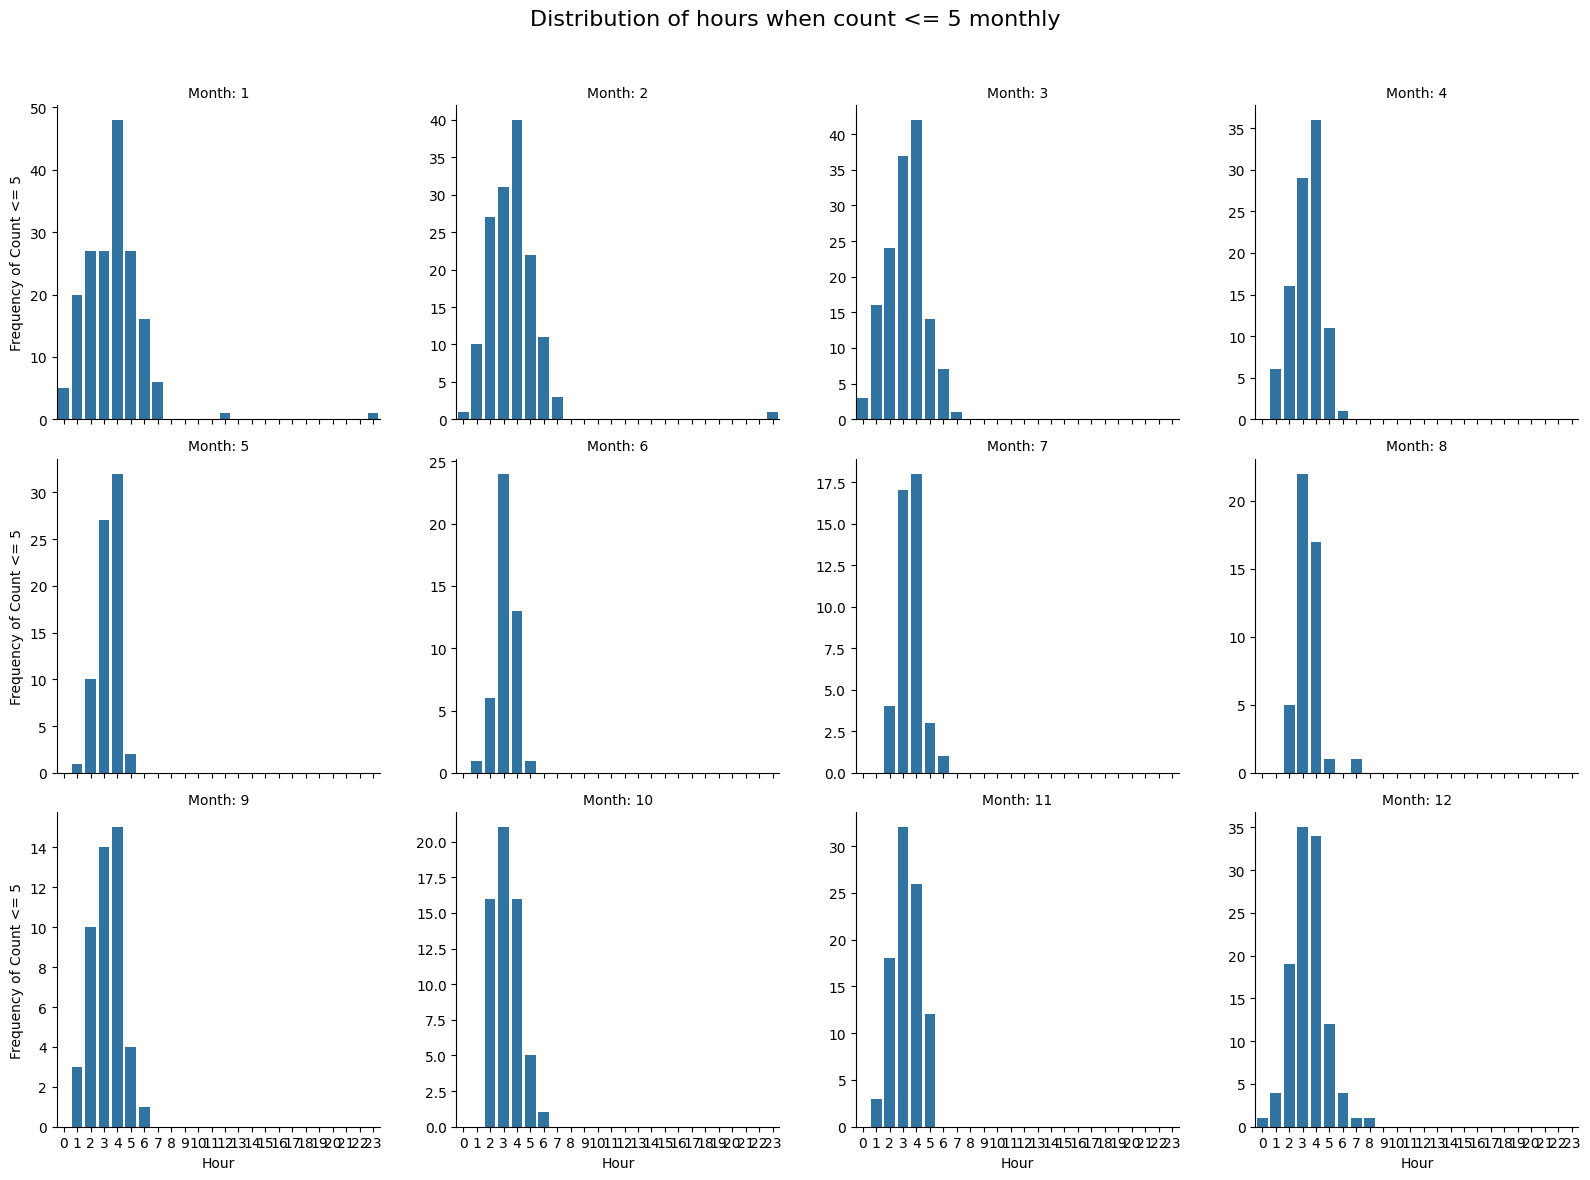

In [522]:
filtered_data = data[(data['cnt'] >= 0) & (data['cnt'] <= 5)]
g = sns.FacetGrid(filtered_data, col="mnth", col_wrap=4, height=4, sharey=False)
g.map(sns.countplot, "hr", order=range(24))
g.set_titles("Month: {col_name}")
g.set_axis_labels("Hour", "Frequency of Count <= 5")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Distribution of hours when count <= 5 monthly", fontsize=16)
plt.show()

The highest frequency of hours with low counts (<= 5) are 3 and 4 in the morning, with the other night hours following a normal distribution around it

We also note higher fequencies for colder months

## Relations between the features and target:

Hour (hr) and Count (cnt)

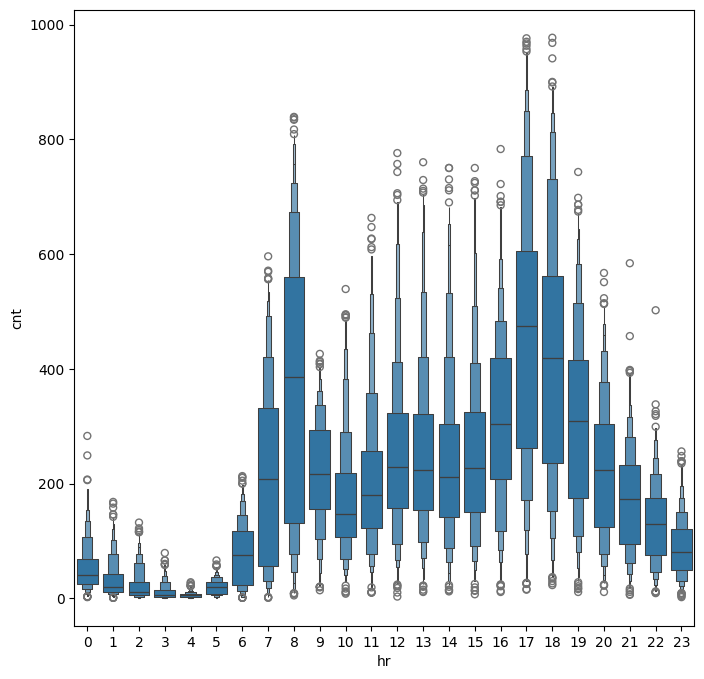

In [523]:
plt.figure(figsize=(8, 8)) 
sns.boxenplot(data=data, x='hr', y='cnt')
plt.show()

We note peak hours at expected times (morning/ evening rush), this pattern might be used at a later stage to develop a variable that captures this pattern

## Difference between working days and non-working days:

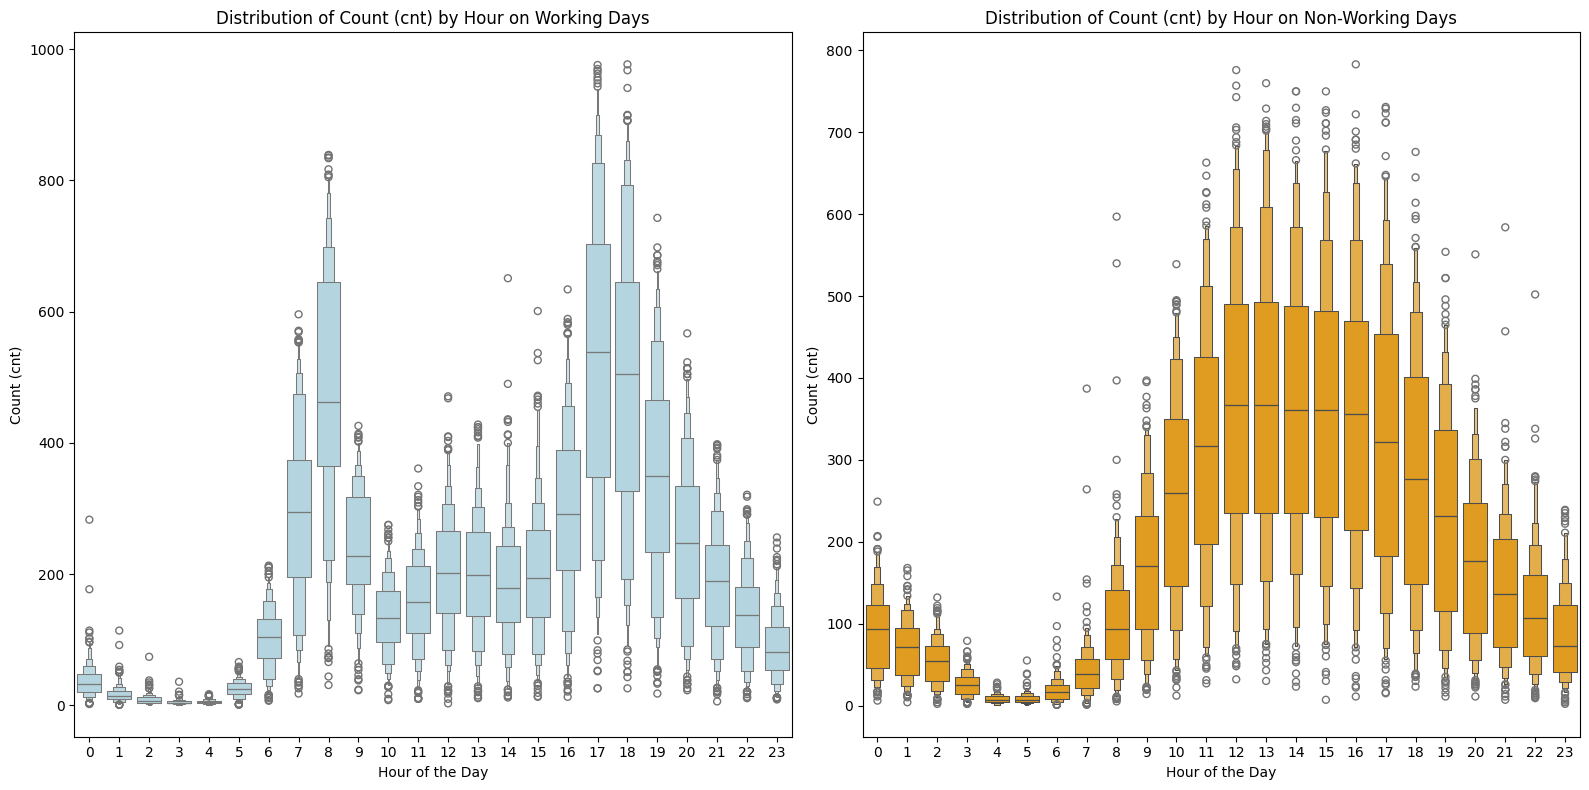

In [524]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.boxenplot(data=data[data['workingday'] == 1], x='hr', y='cnt', color="lightblue")
plt.title("Distribution of Count (cnt) by Hour on Working Days")
plt.xlabel("Hour of the Day")
plt.ylabel("Count (cnt)")
plt.xticks(range(0, 24))

plt.subplot(1, 2, 2)
sns.boxenplot(data=data[data['workingday'] == 0], x='hr', y='cnt', color="orange")
plt.title("Distribution of Count (cnt) by Hour on Non-Working Days")
plt.xlabel("Hour of the Day")
plt.ylabel("Count (cnt)")
plt.xticks(range(0, 24))

plt.tight_layout()
plt.show()


We can see a clear difference between patterns on working and non-working days, if we want to use a feature based on hourly averages, we will need to make a split between working days and non-working days in order to get more precise data

### Influence of month on hourly counts for both working days and non-working days

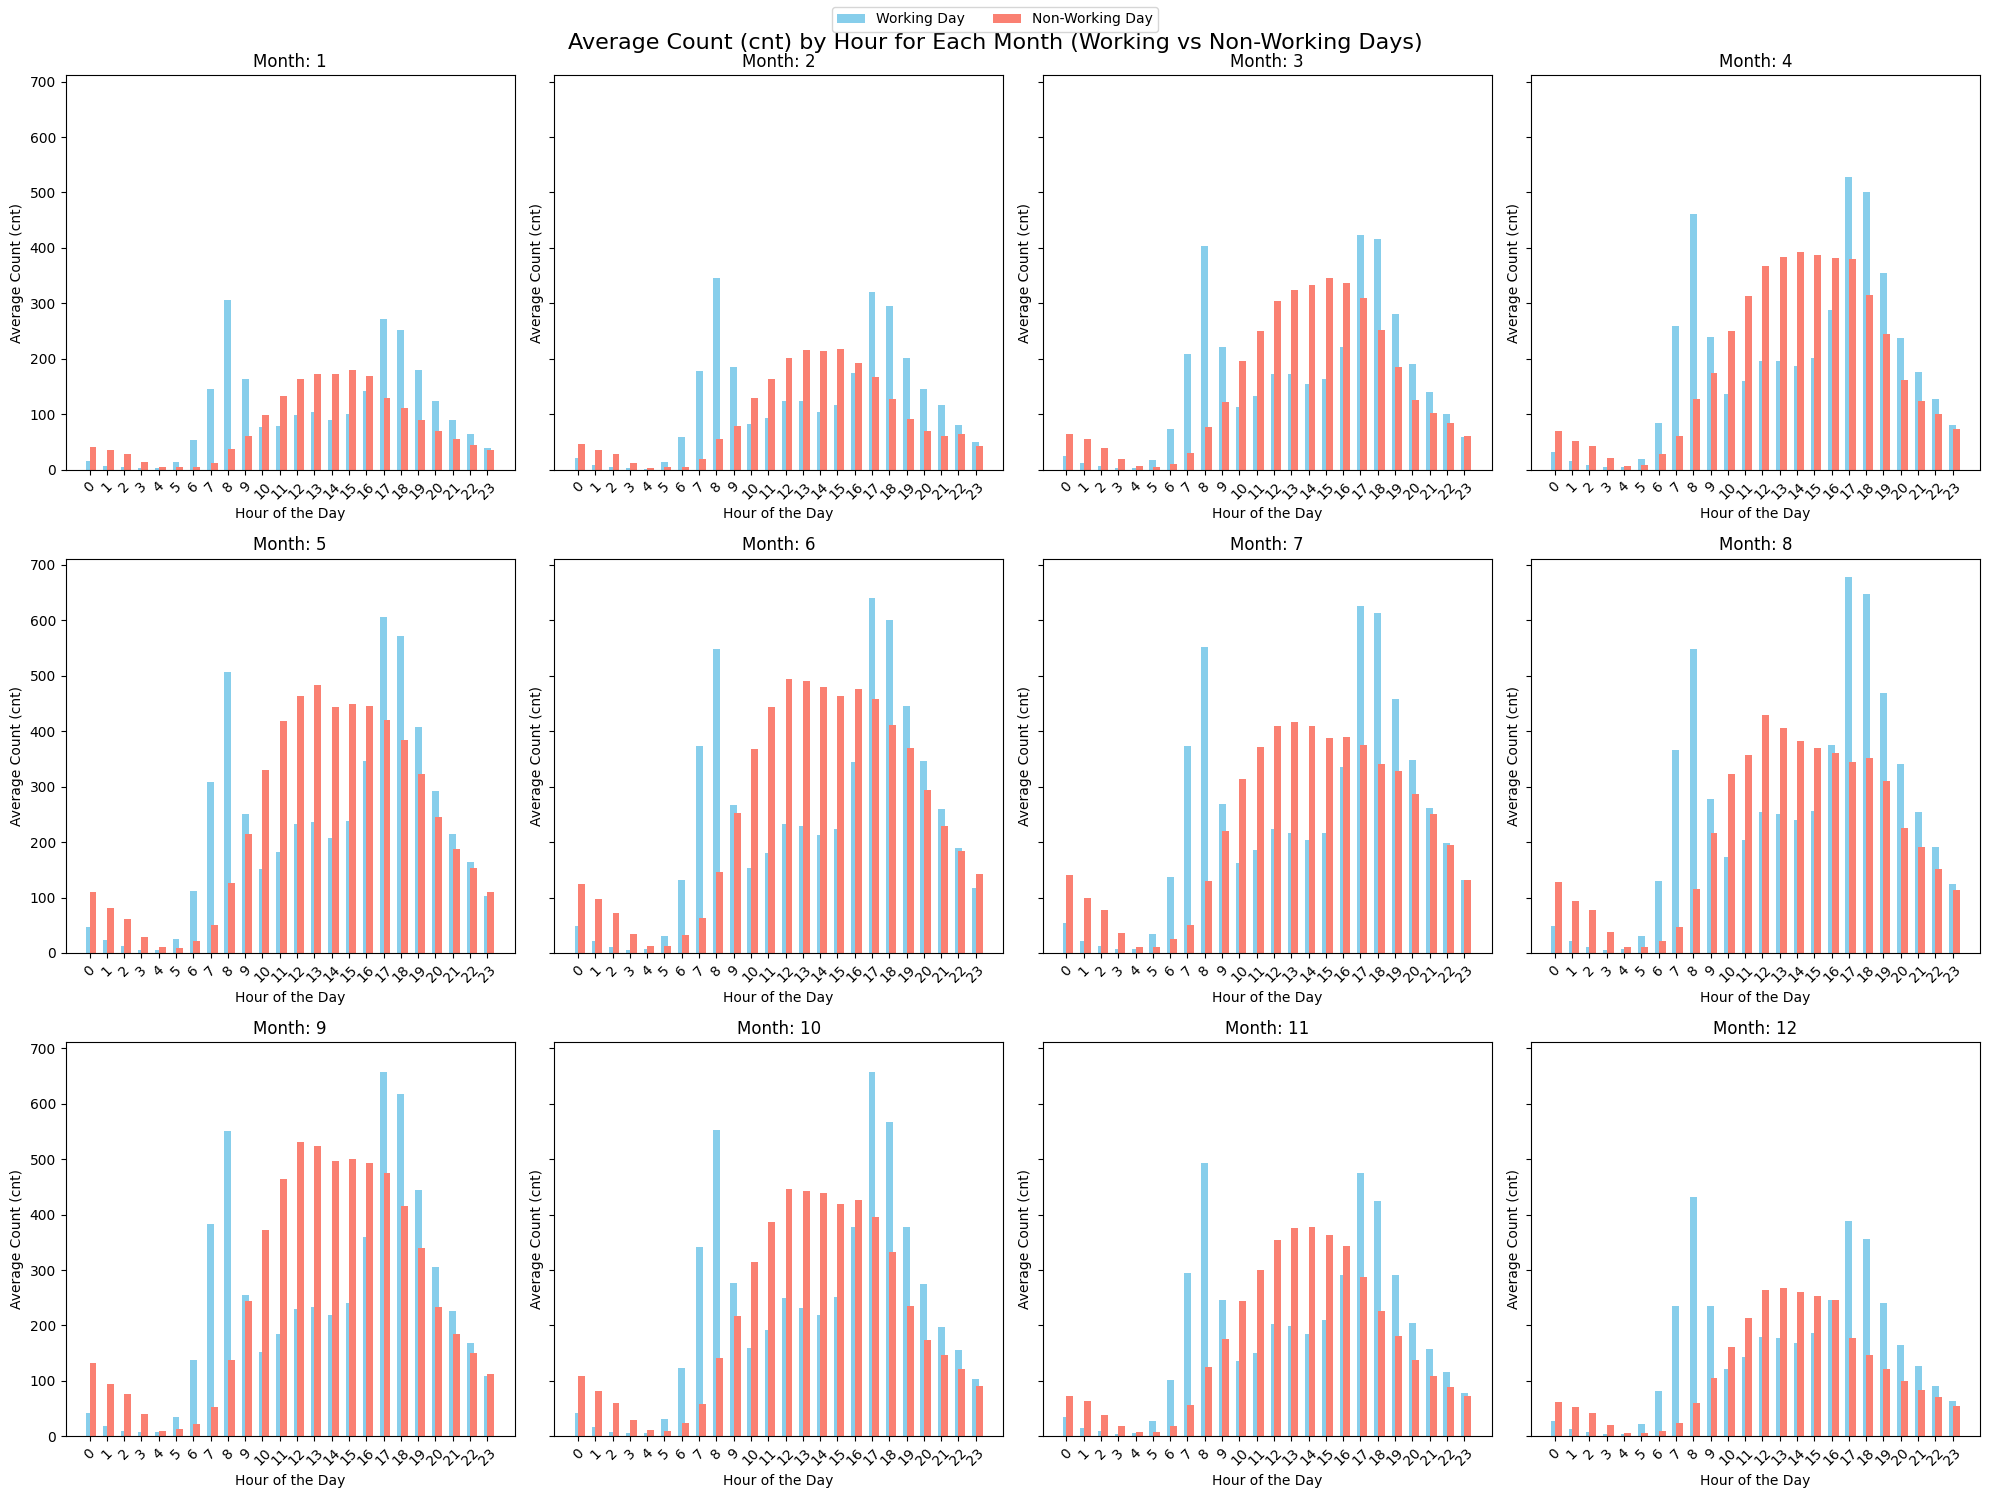

In [525]:
import matplotlib.pyplot as plt

months = data['mnth'].unique()
fig, axes = plt.subplots(3, 4, figsize=(20, 15), sharey=True)
fig.suptitle("Average Count (cnt) by Hour for Each Month (Working vs Non-Working Days)", fontsize=16)

for i, month in enumerate(sorted(months)):

    monthly_data = data[data['mnth'] == month]
    working_data = monthly_data[monthly_data['workingday'] == 1].groupby('hr')['cnt'].mean()
    nonworking_data = monthly_data[monthly_data['workingday'] == 0].groupby('hr')['cnt'].mean()
    hours = range(24)
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    ax.bar(hours, working_data.reindex(hours, fill_value=0), width=0.4, label='Working Day', color='skyblue', align='center')
    ax.bar(hours, nonworking_data.reindex(hours, fill_value=0), width=0.4, label='Non-Working Day', color='salmon', align='edge')
    ax.set_title(f"Month: {month}")
    ax.set_xlabel("Hour of the Day")
    ax.set_ylabel("Average Count (cnt)")
    ax.set_xticks(hours)
    ax.set_xticklabels(hours, rotation=45)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()


Even though the shape of the pattern remains rather stable throughout the months, we can see that warmer months have generally higher counts than colder months.

This is something to take into account when calculating the previously mentioned feature

We can go deeper into the data to see if there is alsa a difference in the days of the week

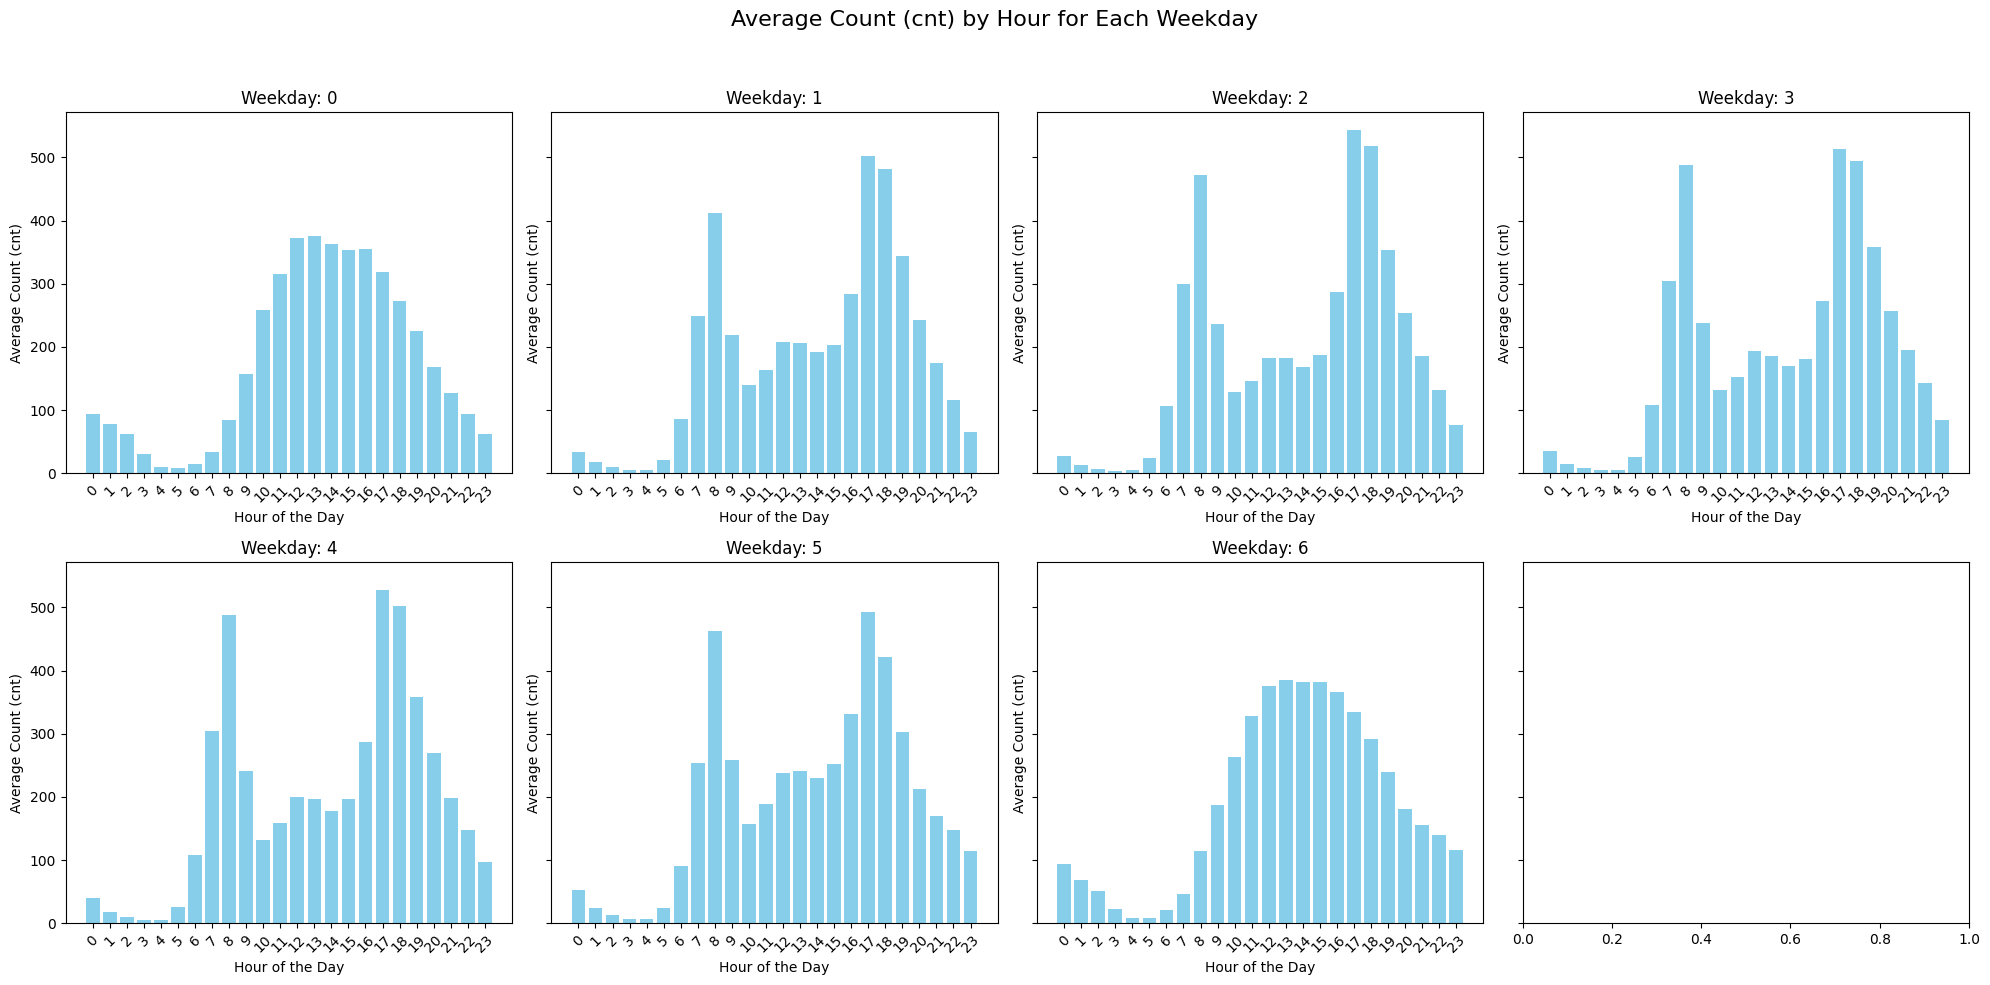

In [526]:
import matplotlib.pyplot as plt

weekdays = data['weekday'].unique()
fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharey=True)
fig.suptitle("Average Count (cnt) by Hour for Each Weekday", fontsize=16)

for i, weekday in enumerate(sorted(weekdays)):
    weekday_data = data[data['weekday'] == weekday].groupby('hr')['cnt'].mean()
    hours = range(24)
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    ax.bar(hours, weekday_data.reindex(hours, fill_value=0), color='skyblue', align='center')
    ax.set_title(f"Weekday: {weekday}")
    ax.set_xlabel("Hour of the Day")
    ax.set_ylabel("Average Count (cnt)")
    ax.set_xticks(hours)
    ax.set_xticklabels(hours, rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Although the difference between the days are not very large (Monday - Friday follows a different pattern, so do Saturday and Sunday), there still is a difference between them that we can include when creating a new variable based on averages.

### creating a variable that captures the average count for each hour, weekday and month for both working days and non-working days:

In [527]:
workingday_counts = data[data['workingday'] == 1].groupby(['mnth', 'weekday', 'hr'])['cnt'].mean()
non_workingday_counts = data[data['workingday'] == 0].groupby(['mnth', 'weekday', 'hr'])['cnt'].mean()

def map_hourly_avg(row):
    if row['workingday'] == 1:
        return workingday_counts.get((row['mnth'], row['weekday'], row['hr']), 0)
    else:
        return non_workingday_counts.get((row['mnth'], row['weekday'], row['hr']), 0)

data['hourly_avg_workingday'] = data.apply(lambda row: map_hourly_avg(row) if row['workingday'] == 1 else 0, axis=1)
data['hourly_avg_nonworkingday'] = data.apply(lambda row: map_hourly_avg(row) if row['workingday'] == 0 else 0, axis=1)

Saving the dataframe with averages so it can be used in streamlit:

In [528]:
workingday_counts = data[data['workingday'] == 1].groupby(['mnth', 'weekday', 'hr'])['cnt'].mean().reset_index()
non_workingday_counts = data[data['workingday'] == 0].groupby(['mnth', 'weekday', 'hr'])['cnt'].mean().reset_index()
workingday_counts.to_csv('workingday_counts_with_weekday.csv', index=False)
non_workingday_counts.to_csv('non_workingday_counts_with_weekday.csv', index=False)

This variable does create an issue: Due to the fact that Monday-Friday are rarely non-workingdays, we will no be able to calculate accurate average hourly data for them.

We will fix this by including a function in the streamlit code that imputes the average hourly values for Saturday when the input is Monday-Friday and non-workingday

## Relationship between weather variables and count:

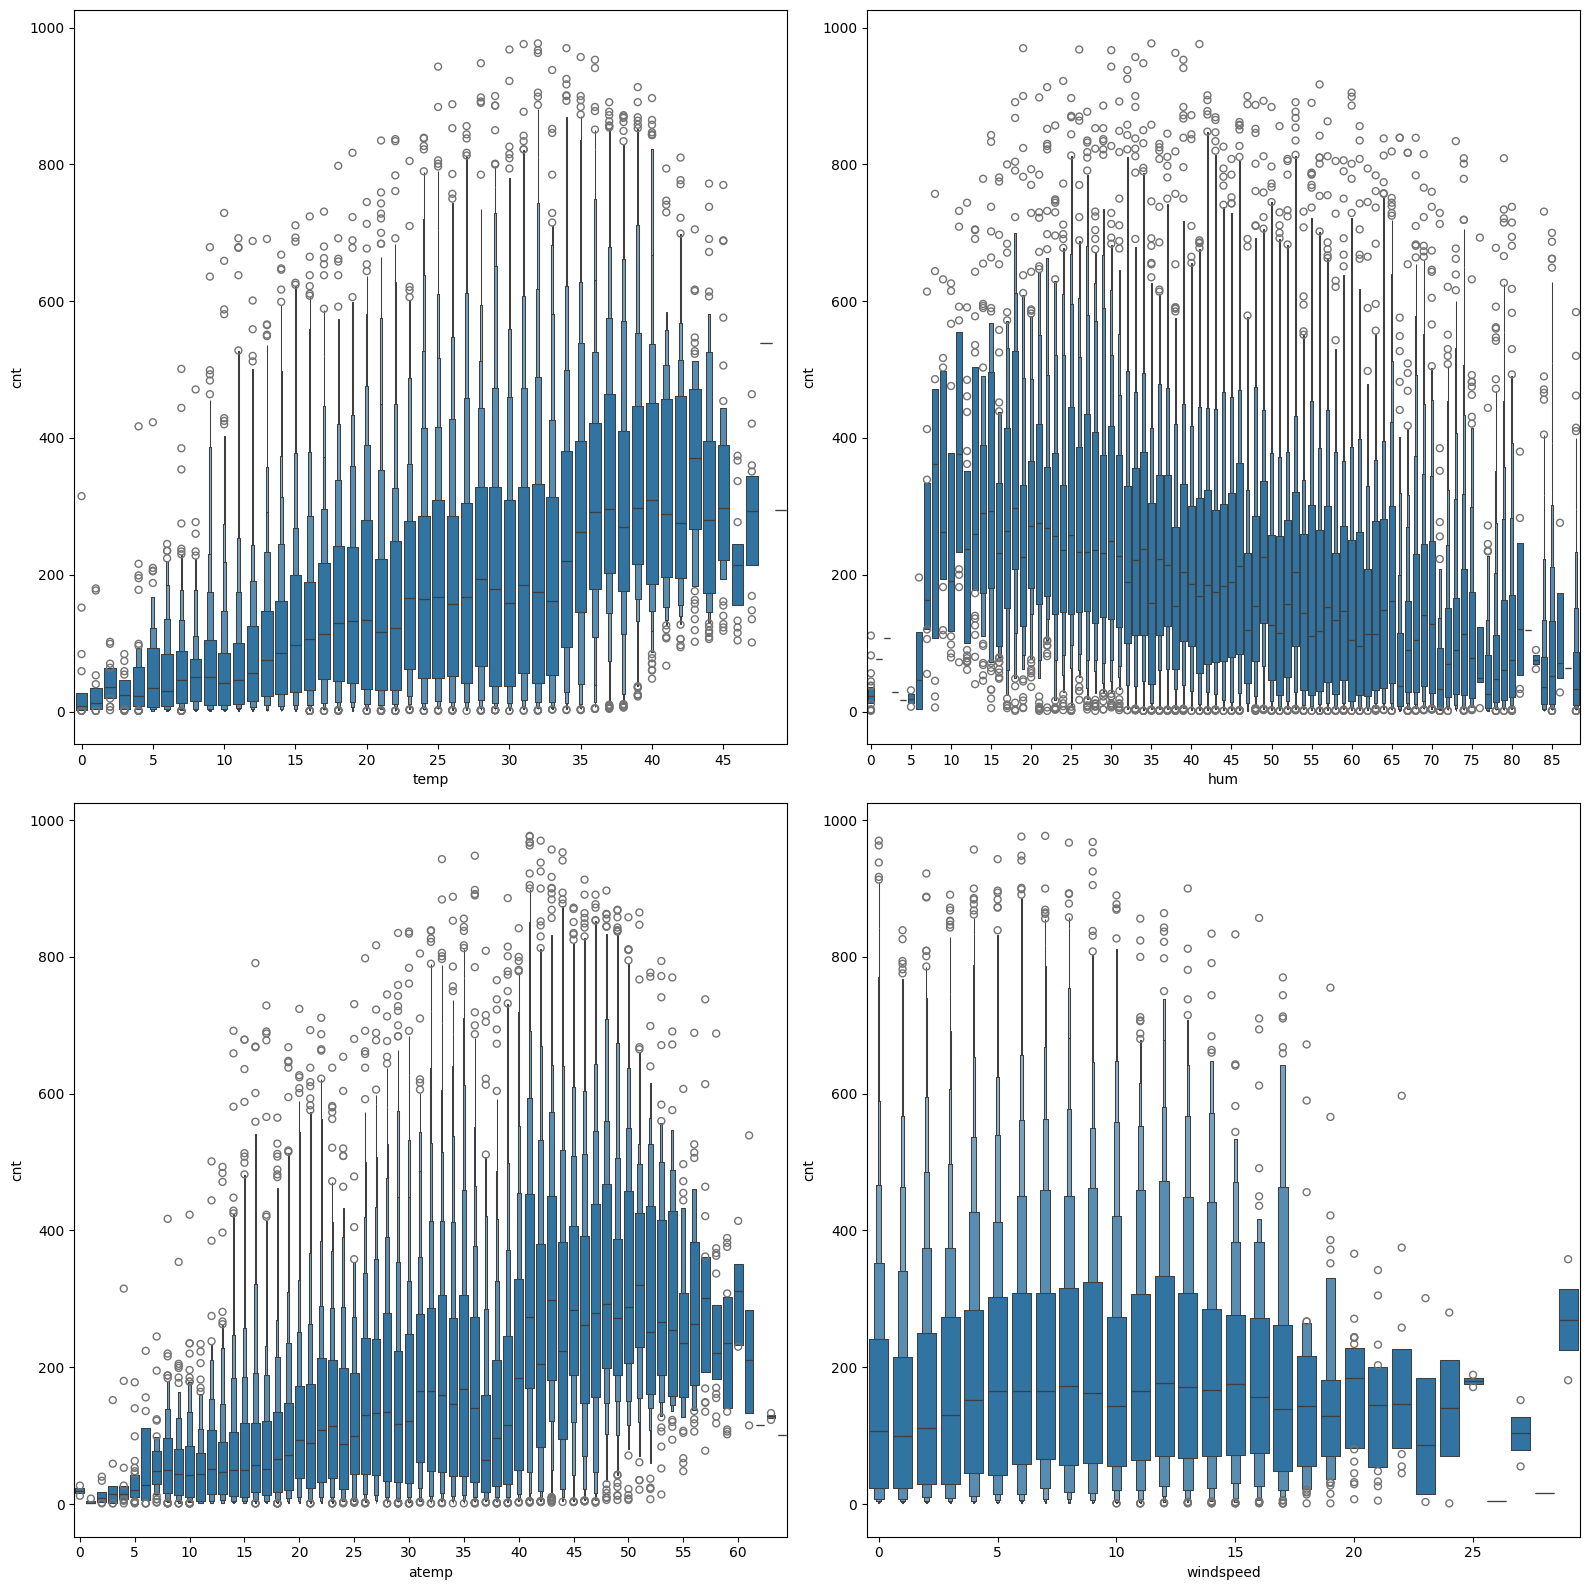

In [529]:
variables = ['temp', 'hum', 'atemp', 'windspeed']
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes = axes.flatten()
for i, var in enumerate(variables):
    sns.boxenplot(data=data, x=var, y='cnt', ax=axes[i])
    x_axis_values = range(0, len(data[var].unique()), 5)
    axes[i].set_xticks(x_axis_values)
    axes[i].set_xticklabels([int(x) for x in axes[i].get_xticks()])
plt.tight_layout()
plt.show()

We note an increase in counts for higher temperatures, and then a drop for more extreme values.
temp and atemp seem to behave similarly as expected, we will have to investigate it further as they do have a different range
(We see some temperatures above 45 degrees, after checking online we found that this does happen in Washington)

We see that humidity has a negative effect on counts, this could be due to the fact that humidity can cause rain and storms

We see no real effect of windspeed on counts, only for the extreme values, we might want to turn it into a categorical variable (high_windspeed yes/no) 



## Creating a windspeed category:

In [530]:
bins = [data['windspeed'].min() - 1, 40, data['windspeed'].max() + 1]
labels = [1, 2]
data['windspeed_binned'] = pd.cut(data['windspeed'], bins=bins, labels=labels, right=False).astype(int)

We categorise high windspeed for speeds above 40

### Effect of windspeed_binned on count:

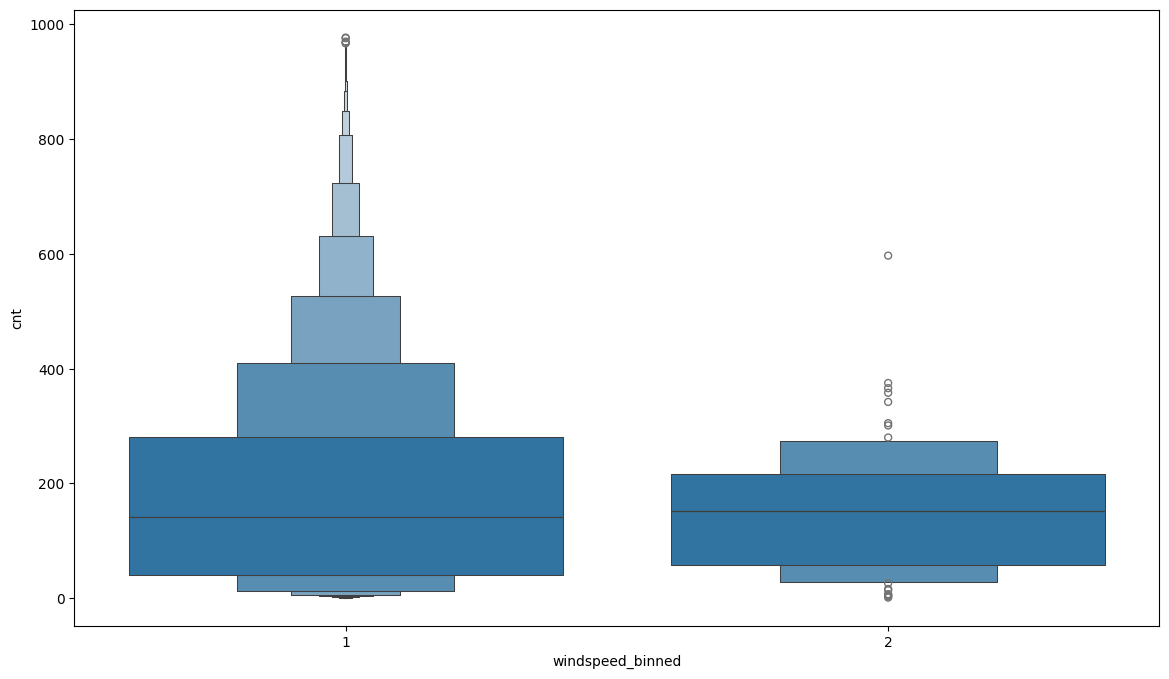

In [531]:
plt.figure(figsize=(14, 8)) 
sns.boxenplot(data=data, x='windspeed_binned', y='cnt')
plt.show()

There seems to be nog big effect of the categorised windspeeds on average count, actually the opposite of what we expected. We have to investigate further

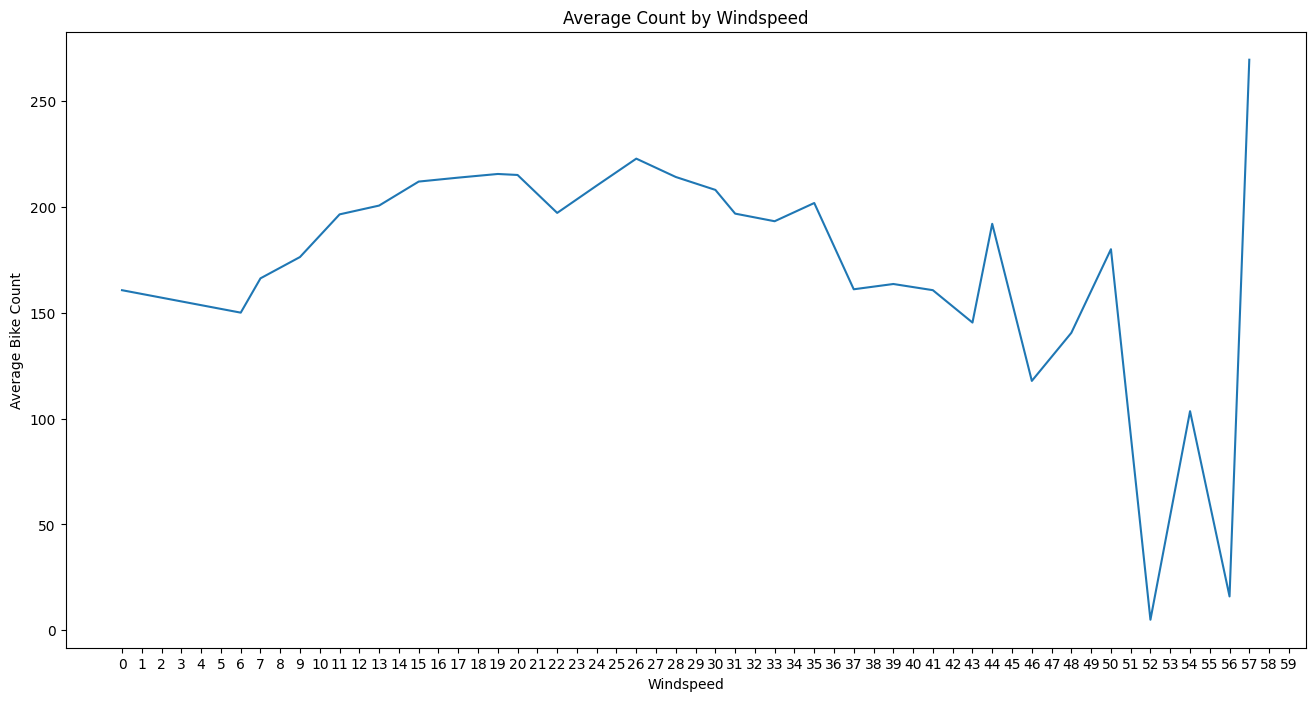

In [532]:
average_count_by_windspeed = data.groupby('windspeed')['cnt'].mean().reset_index()
plt.figure(figsize=(16, 8))
sns.lineplot(x='windspeed', y='cnt', data=average_count_by_windspeed)
plt.xlabel('Windspeed')
plt.ylabel('Average Bike Count')
plt.title('Average Count by Windspeed')
plt.xticks(range(0, int(60)))
plt.show()

We notice a large peak for the highest windspeed, when going through the data, we find (56.99 ; 358), this point, together with a few other points divert from the downward trend that we expect

these few points can heavily influence the average counts in the bins, as we expect there to be less data in this bin compared to the other bin

Due to the large variance in counts for windspeeds in the first bin, the average might not be very useful

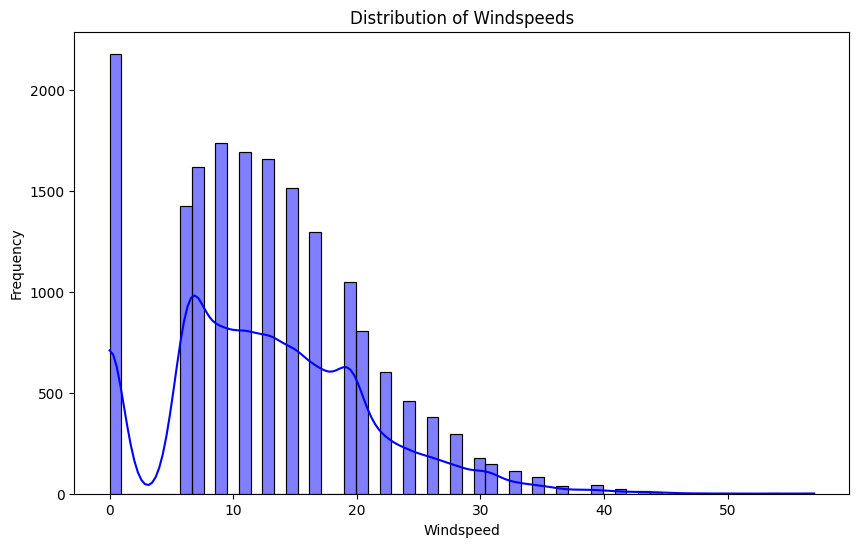

Above 40: 63, Below 40: 17316


In [533]:
plt.figure(figsize=(10, 6))
sns.histplot(data['windspeed'], kde=True, bins=60, color='blue')
plt.xlabel('Windspeed')
plt.ylabel('Frequency')
plt.title('Distribution of Windspeeds')
plt.show()

count_above = (data['windspeed'] > 40).sum()
count_below = (data['windspeed'] < 40).sum()
print(f"Above 40: {count_above}, Below 40: {count_below}")

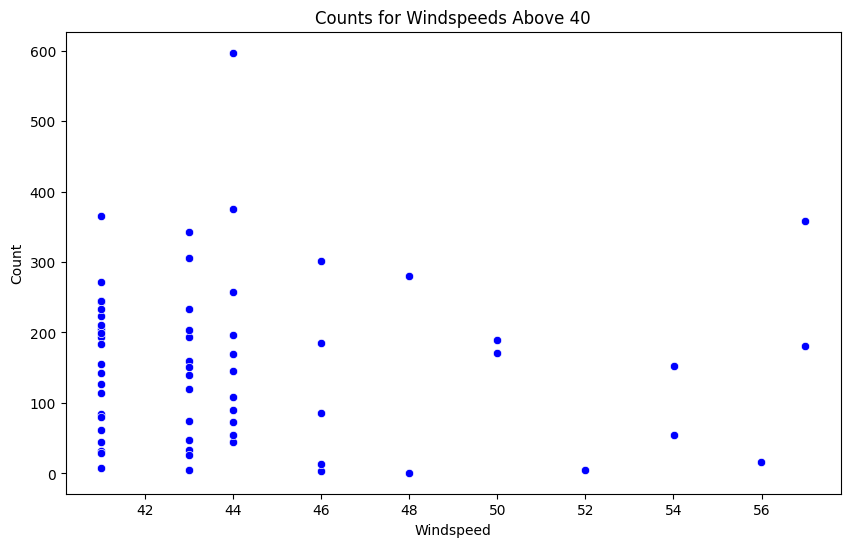

In [534]:
filtered_data = data[data['windspeed'] > 40]
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_data, x='windspeed', y='cnt', color='blue')
plt.xlabel('Windspeed')
plt.ylabel('Count')
plt.title('Counts for Windspeeds Above 40')
plt.show()

This confirms there is less data available, thus meaning the mean will be heavily influenced by these few points

We will decide after further analysis whether to include windspeed_binned, windspeed or none of the 2 as a variable and finetune it if needed

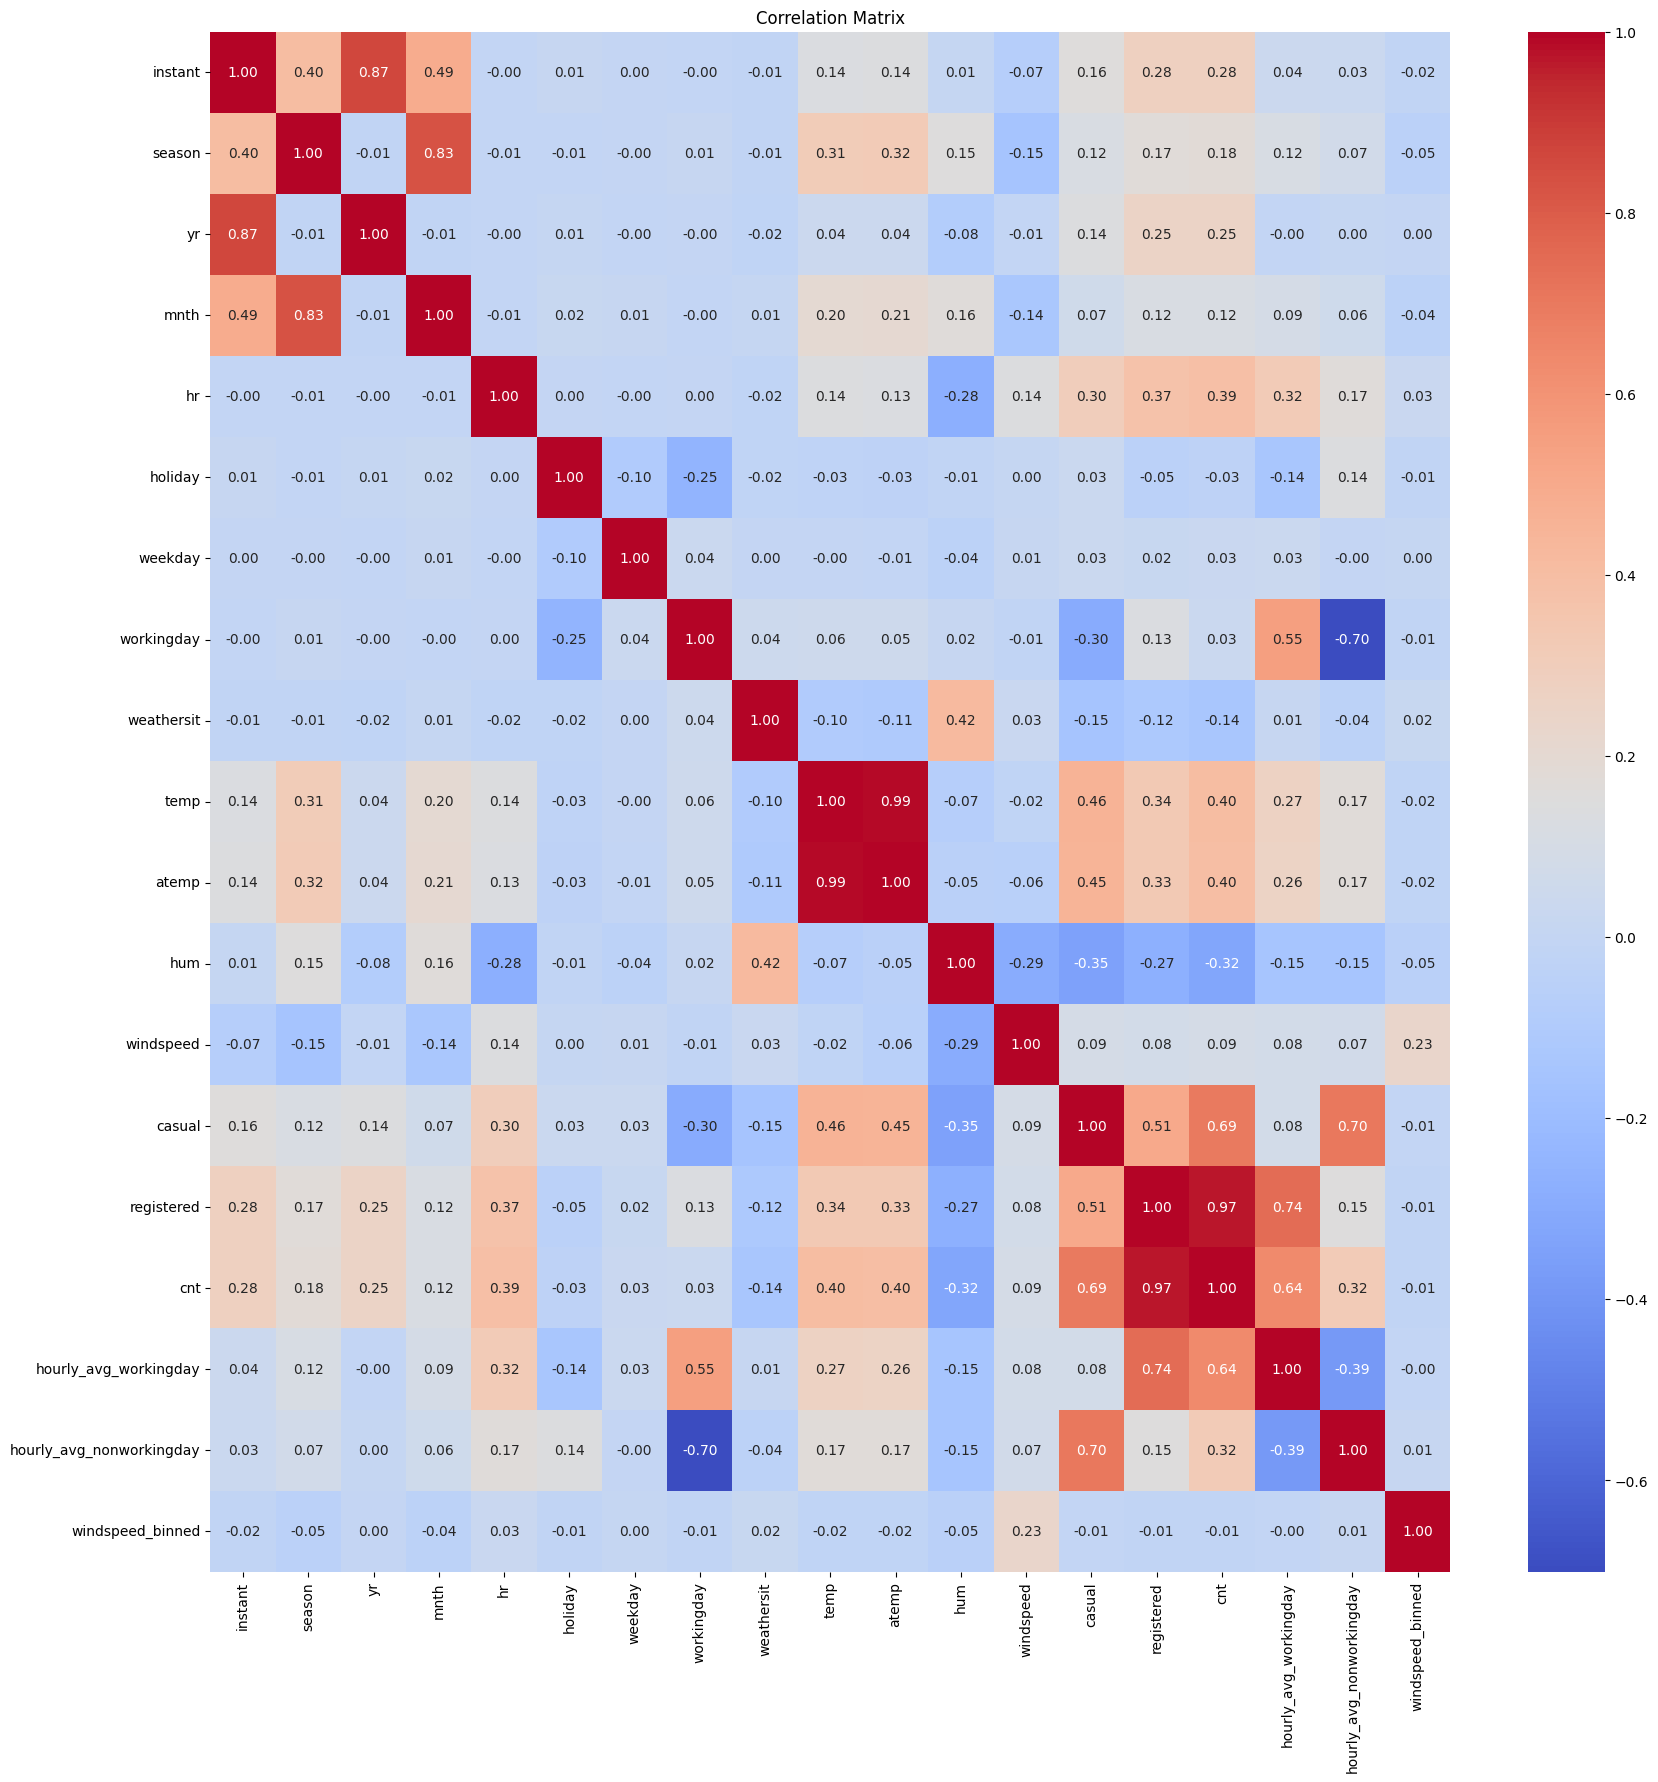

In [535]:
num_data = data.select_dtypes(include=['number'])
correlation_matrix = num_data.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Matrix')
plt.show()


The correlation matrix shows a lower significance for the categorised variable than for the continuous variable

We will test both on the model to see what gives the best results

## Lagged variables:

We saw that temperature has an effect on count, but what about expected temperature for a given hour? We can calculate this by calculating different lags of temperature

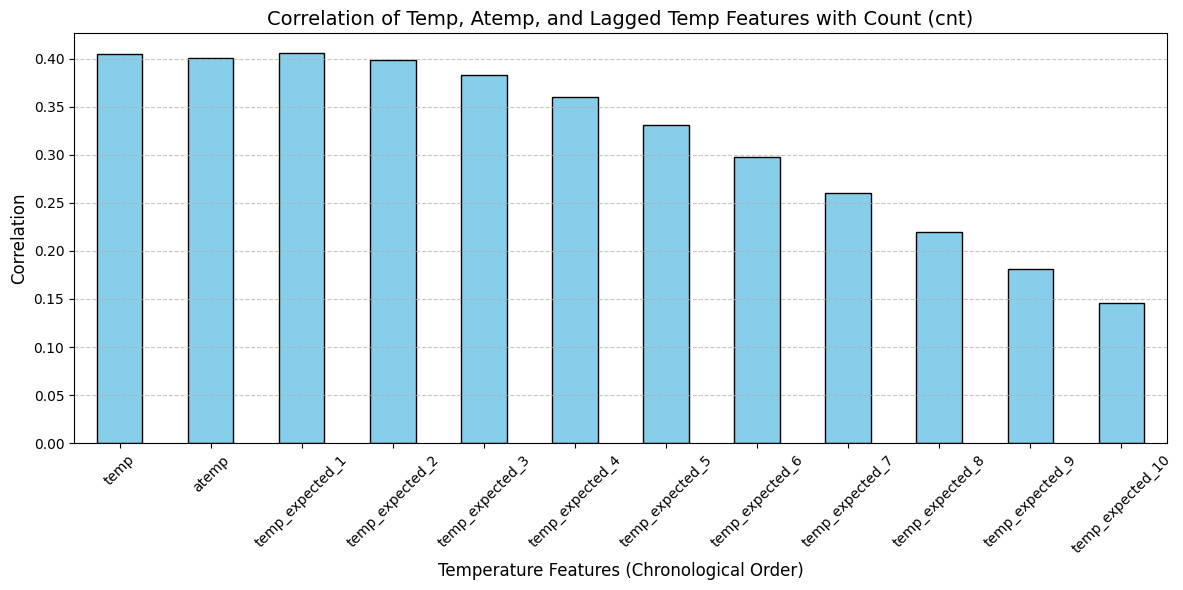

                  Correlation
temp                 0.404772
atemp                0.400929
temp_expected_1      0.406037
temp_expected_2      0.398753
temp_expected_3      0.383297
temp_expected_4      0.360155
temp_expected_5      0.331151
temp_expected_6      0.297453
temp_expected_7      0.259724
temp_expected_8      0.219990
temp_expected_9      0.180843
temp_expected_10     0.145901


In [536]:
correlations = {
    'temp': data['cnt'].corr(data['temp']),
    'atemp': data['cnt'].corr(data['atemp'])
}

for lag in range(-1, -11, -1):
    col_name = f'temp_expected_{abs(lag)}'
    data[col_name] = data['temp'].shift(lag)
    correlations[col_name] = data['cnt'].corr(data[col_name])
correlation_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation'])
correlation_df = correlation_df.reindex(
    sorted(correlation_df.index, key=lambda x: int(x.split('_')[-1]) if 'expected' in x else -11)
)

plt.figure(figsize=(12, 6))
correlation_df['Correlation'].plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Correlation of Temp, Atemp, and Lagged Temp Features with Count (cnt)', fontsize=14)
plt.ylabel('Correlation', fontsize=12)
plt.xlabel('Temperature Features (Chronological Order)', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(correlation_df)

The 1-hour lagged variable seems to have the highest correlation with count, this could be due to the fact that people check the weather before deciding on their transport

However, as temperature generally only changes by a few degrees within an hour, we have to check for autocorrelation

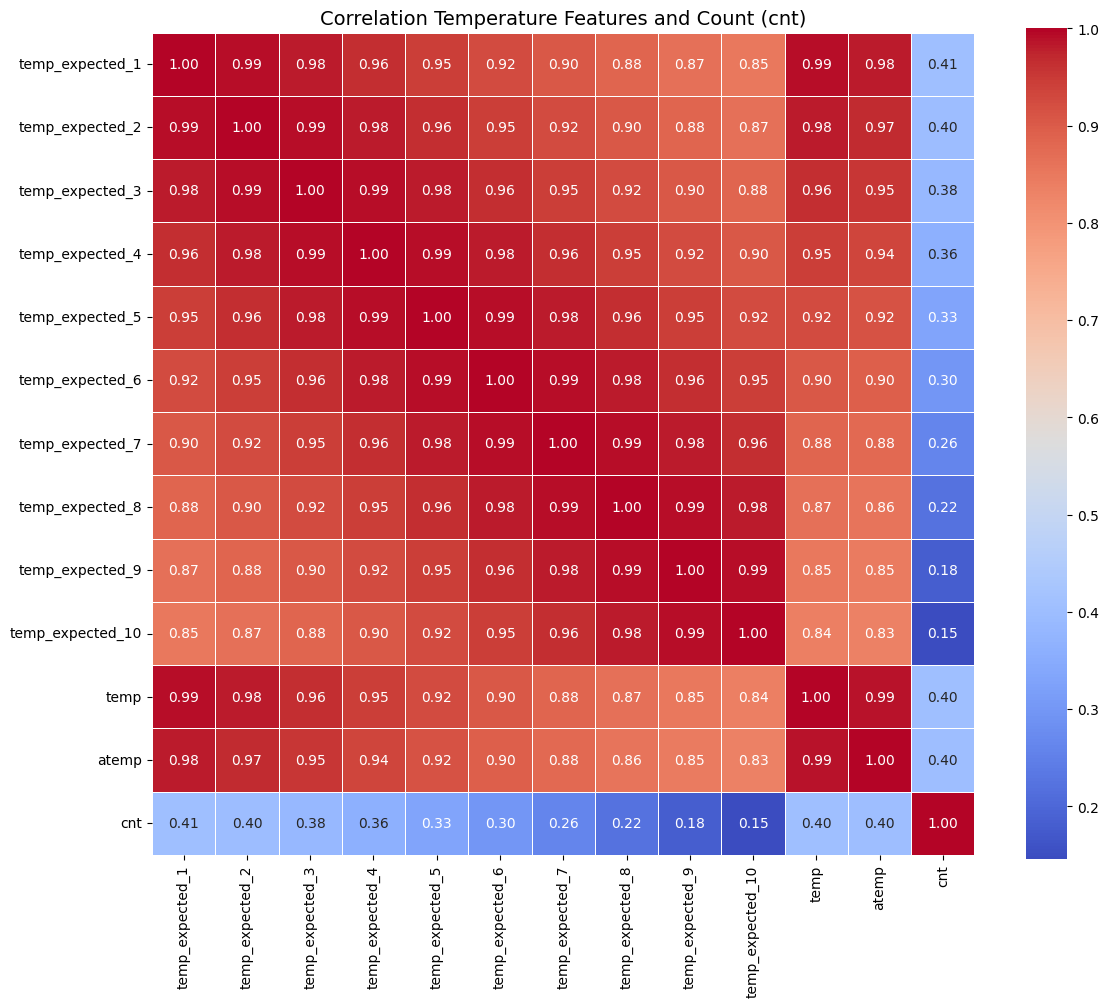

In [537]:
import seaborn as sns
import matplotlib.pyplot as plt
for lag in range(1, 11):
    col_name = f'temp_expected_{lag}'
    data[col_name] = data['temp'].shift(-lag)
data.fillna(0, inplace=True)
selected_features = [f'temp_expected_{i}' for i in range(1, 11)] + ['temp', 'atemp']
correlation_matrix = data[selected_features + ['cnt']].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5,
    cbar=True,
    square=True
)
plt.title('Correlation Temperature Features and Count (cnt)', fontsize=14)
plt.tight_layout()
plt.show()

We can see high correlation between the temperature features, meaning it's best and logical to unly use one in the model.

As temp_expected_1 seems to give the best results, we will consider it for our model and compare it to  temp and atemp

In [538]:
lagged_features = [col for col in data.columns if 'temp_expected_' in col]
for lag in lagged_features:
    if lag != 'temp_expected_1':
        data.drop(columns=[lag], inplace=True)

We applied the same logic to the other weather features but the lagged features performed worse that the original features

### Effect of weathersit on count:

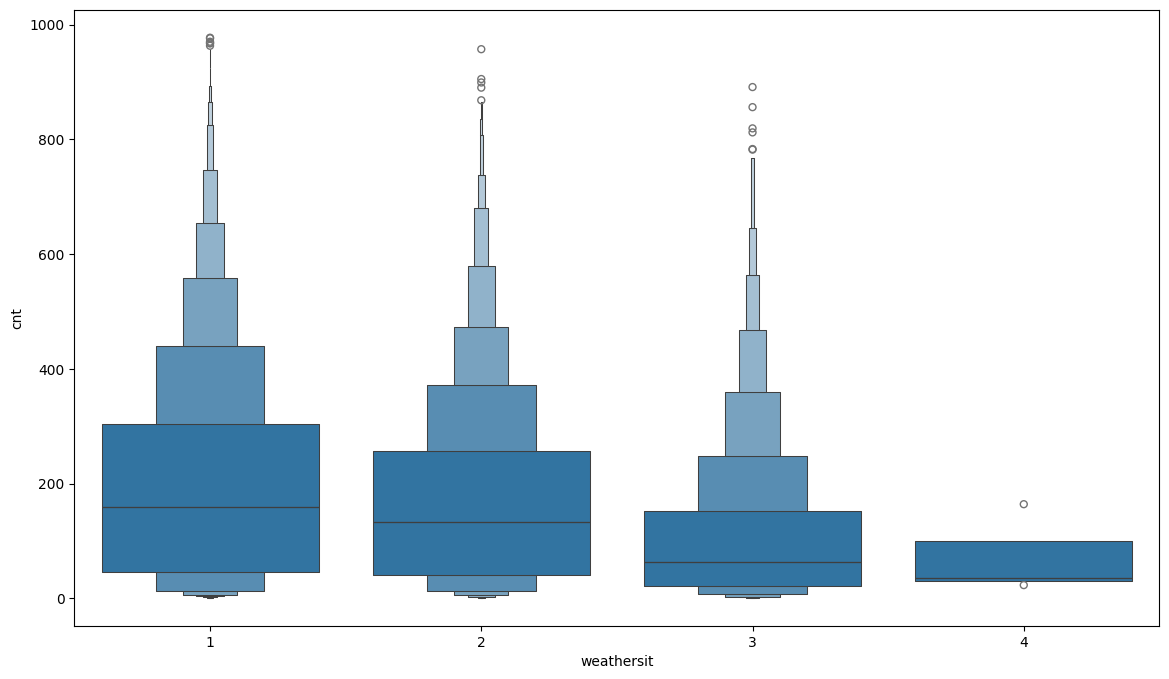

In [539]:
plt.figure(figsize=(14, 8)) 
sns.boxenplot(data=data, x='weathersit', y='cnt')
plt.show()

Weathersit 1 and 2 seem to have similar effects on count while 3 and 4 share resemblances as well.

This is likely due to the fact that weathersit 3 and 4 mean there is precipitation.

Instead of using 4 weathersits, we can bin them into 2 bins to simplify our model: dry (1 and 2) and precipitation (3 and 4)

In [540]:
data['dry_precip'] = data['weathersit'].apply(
    lambda x: 1 if x in [1, 2] else 2
)

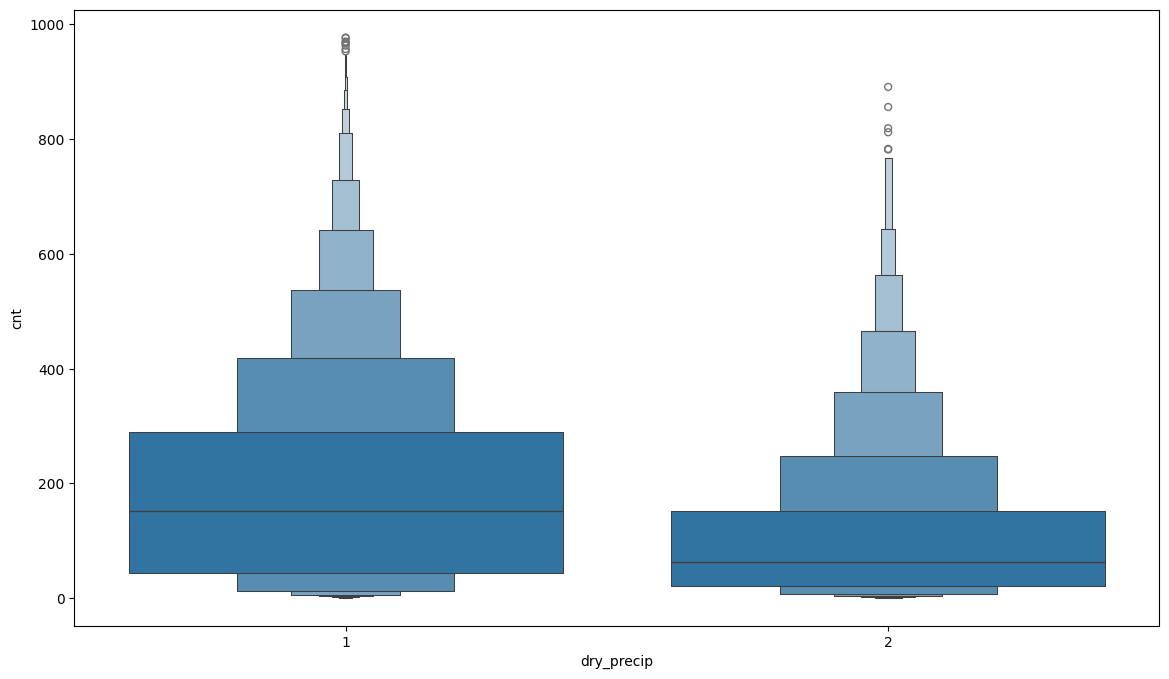

In [541]:
plt.figure(figsize=(14, 8)) 
sns.boxenplot(data=data, x='dry_precip', y='cnt')
plt.show()

We now see a clear difference between the two bins, let's investigate further:

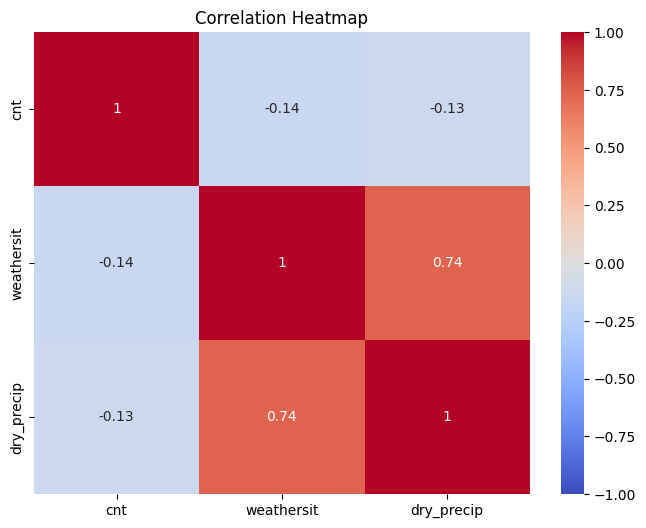

In [542]:
correlation_data = data[['cnt', 'weathersit', 'dry_precip']]
correlation_matrix = correlation_data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=True)
plt.title('Correlation Heatmap')
plt.show()

The new binned data seems to have a similar correlation as expected, we will have to try both features on the model and assess which one to use

### Precipitation intensity bins:

Instead of creating 2 bins, we can create 3 based on precipitation intensity where weathersit 1 and 2 are dry, 3 would be precipitation and 4 would be heavier precipitation:

In [543]:
data['rain_intensity'] = data['weathersit'].apply(
    lambda x: 1 if x in [1, 2] else (2 if x == 3 else 3)
)

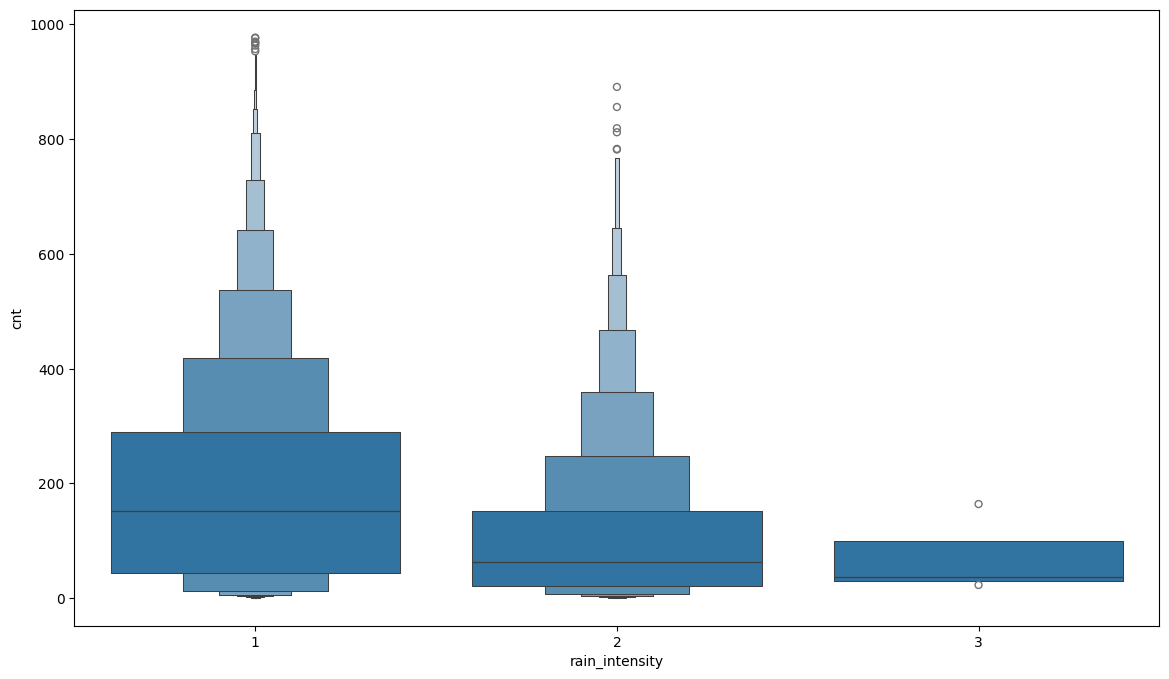

In [544]:
plt.figure(figsize=(14, 8)) 
sns.boxenplot(data=data, x='rain_intensity', y='cnt')
plt.show()

Again we see a clear difference between the bins, however bin 3 seems to contain lesser data, which is logical for extreme situations.

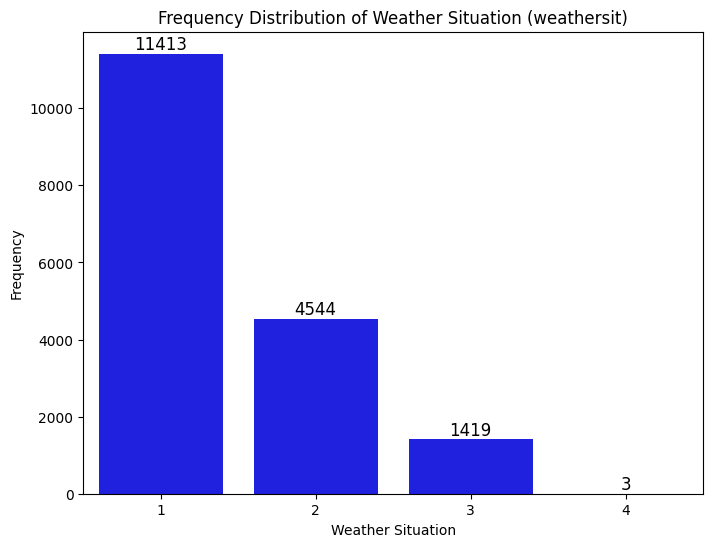

In [545]:
plt.figure(figsize=(8, 6))
sns.countplot(x='weathersit', data=data, color='blue')
plt.title('Frequency Distribution of Weather Situation (weathersit)')
plt.xlabel('Weather Situation')
plt.ylabel('Frequency')
counts = data['weathersit'].value_counts()
for i, count in enumerate(counts):
    plt.text(i, count + 1, str(count), ha='center', va='bottom', fontsize=12)
plt.show()

As expected weathersit 4 contains very limited data, we will not consider precip_intensity for our model

# PART II: Feature Selection

We'll start with a shortlist of features that we are  interested in.

Dropping features from 'data' that we are not considering:

    temp & atemp: as we created a lagged version, we cannot use the original.

    dteday: We are not building our model on a timeseries.

    instant: is like an index.
    
    registered & casual: Count is directly calculated from the sum, if we know registered and casual, we wouldn't need a model.

    season: As we have monthly data, which holds more information and has a strong collinearity, we drop season.
    
    hr: As we calculated hourly averages, we don't use hr in the model but rather in the inputs to use the matching hourly average.
    
    workingday: As we calculated hourly averages for workingdays and non-workingdays, we don't use workingday in the model but rather in the inputs to use the matching hourly average.
    
    weekday: As we calculated hourly averages based on weekday, we don't use weekday in the model but rather in the inputs to use the matching hourly average.

    windspeed & windspeed_binned: As we are predicting in the future, and our research showed that predicting windspeed for a given hour is inaccurate, together with the low correlation with count, we drop it.

    





In [546]:
data = data.drop(columns=['dteday','temp', 'atemp', 'instant', 'registered', 'casual', 'season','hr', 'workingday','weekday', 'windspeed','windspeed_binned'])

In [547]:
X = data.drop(columns=['cnt'])
y=data['cnt']

In [548]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

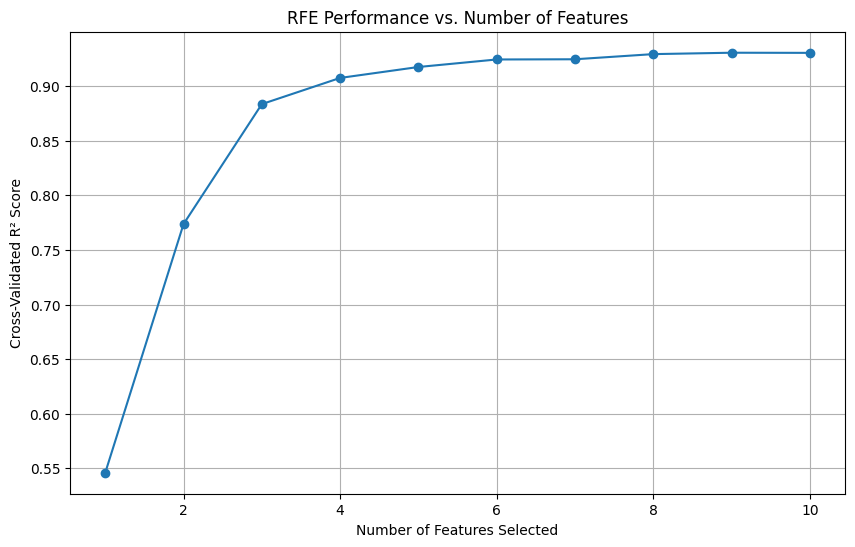

In [549]:
model = GradientBoostingRegressor()

rfecv = RFECV(
    estimator=model,
    step=1,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

rfecv.fit(X_train, y_train)
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
    rfecv.cv_results_['mean_test_score'],
    marker='o'
)
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-Validated R² Score")
plt.title("RFE Performance vs. Number of Features")
plt.grid()
plt.show()

We see a steep increase in performance until we reach 8 futures.

In [550]:
feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else np.arange(X_train.shape[1])
n_features = X_train.shape[1]
feature_ranking = rfecv.ranking_
target_num_features = 8
selected_features_at_target = np.argsort(feature_ranking)[:target_num_features]
selected_feature_names = feature_names[selected_features_at_target]
print(f"Features selected for {target_num_features} features:")
print(selected_feature_names)

Features selected for 8 features:
Index(['yr', 'mnth', 'weathersit', 'hum', 'hourly_avg_workingday',
       'hourly_avg_nonworkingday', 'temp_expected_1', 'dry_precip'],
      dtype='object')


After selecting the 8 best features, we see the following:

'yr', 'mnth', 'weathersit', 'hum', 'hourly_avg_workingday', 'hourly_avg_nonworkingday', 'temp_expected_1', 'rain_intensity'

We do have to decide between rain_intensity and weathersit. As weathersit has a higher correlation with count, we will drop rain_intensity.




# PART III: Prediction Model

In [551]:
X = data[['yr', 'mnth', 'weathersit', 'hum', 'hourly_avg_workingday', 'hourly_avg_nonworkingday', 'temp_expected_1']]
y = data['cnt']

In [552]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [553]:
X.head()

,yr,mnth,weathersit,hum,hourly_avg_workingday,hourly_avg_nonworkingday,temp_expected_1
0,0,1,1,81.0,0.0,36.222222,9.02
1,0,1,1,80.0,0.0,33.444444,9.02
2,0,1,1,80.0,0.0,25.444444,9.84
3,0,1,1,75.0,0.0,12.555556,9.84
4,0,1,1,75.0,0.0,3.888889,9.84


In [554]:
categorical_features = ['yr', 'mnth', 'weathersit']
encoder = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough',
    force_int_remainder_cols=False
)

### Checking for collinearity between the selected features

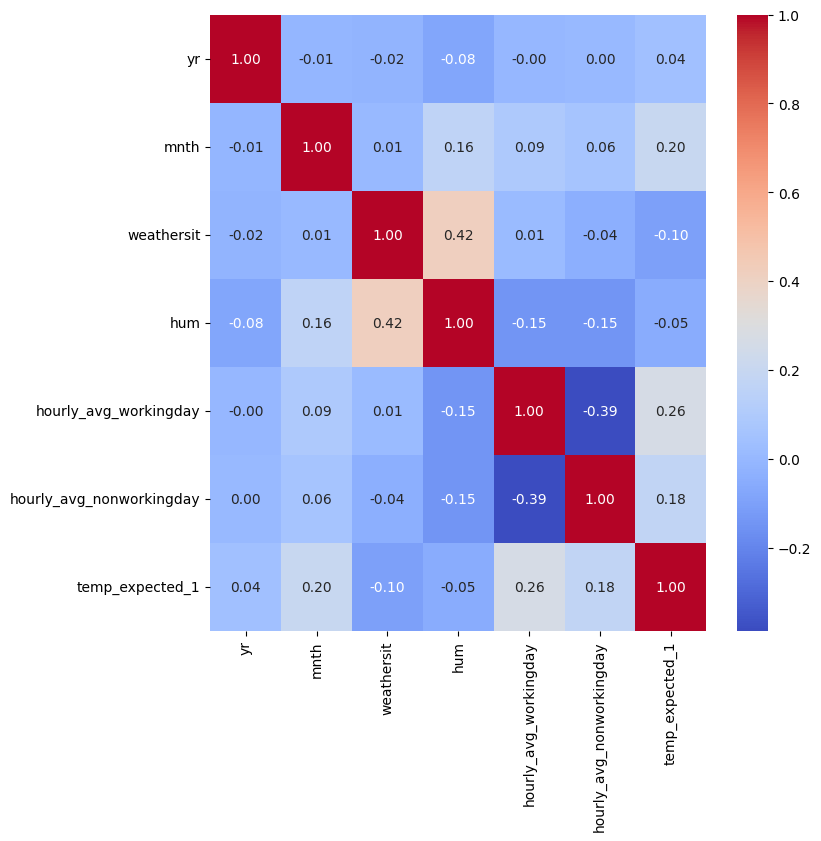

In [555]:
corr_matrix = X.corr()
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

There is collinearity between between hourly_avg_workingday and hourly_avg_nonworkingday. this will not be an issue as they are mutually exclusive, meaning only one of the 2 is used for predicting the count based on the input data. They will never be used together for the same hour.

## Gradient Boosting Regressor:

In [556]:
gbr = GradientBoostingRegressor()

param_dist = {
    'n_estimators': [400, 450, 500, 550, 600, 650],
    'learning_rate': [0.02, 0.04, 0.05, 0.06, 0.07, 0.1],
    'max_depth': [2, 3, 4, 5, 6, 7],
    'min_samples_split': [30, 35, 40, 45, 55],
    'min_samples_leaf': [6, 7, 8, 9, 10],
    'subsample': [0.7, 0.85, 0.9, 0.95, 1.0],
    'max_features': [None, 'sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_dist,
    n_iter=10,
    cv=10,
    verbose=1,
    n_jobs=-1,
    random_state=42,
    scoring='neg_mean_squared_error'
)

In [557]:
pipeline = Pipeline(steps=[
    ('encoder', encoder),
    ('random_search', random_search)
])

pipeline.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Pipeline(steps=[('encoder',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['yr', 'mnth',
                                                   'weathersit'])])),
                ('random_search',
                 RandomizedSearchCV(cv=10,
                                    estimator=GradientBoostingRegressor(),
                                    n_jobs=-1,
                                    param_distributions={'learning_rate': [0.02,
                                                                           0.04,
                                                                           0.05,
                                                                           0.06,
                                                                           0.07,
                                                                           0.1],
                                                         'max_depth': [2, 3, 4,
                                                                       5, 6,
                                                                       7],
                                                         'max_features': [None,
                                                                          'sqrt',
                                                                          'log2'],
                                                         'min_samples_leaf': [6,
                                                                              7,
                                                                              8,
                                                                              9,
                                                                              10],
                                                         'min_samples_split': [30,
                                                                               35,
                                                                               40,
                                                                               45,
                                                                               55],
                                                         'n_estimators': [400,
                                                                          450,
                                                                          500,
                                                                          550,
                                                                          600,
                                                                          650],
                                                         'subsample': [0.7,
                                                                       0.85,
                                                                       0.9,
                                                                       0.95,
                                                                       1.0]},
                                    random_state=42,
                                    scoring='neg_mean_squared_error',
                                    verbose=1))])

In [558]:
best_model = pipeline.named_steps['random_search'].best_estimator_
best_params = pipeline.named_steps['random_search'].best_params_
best_score = pipeline.named_steps['random_search'].best_score_
train_predictions = pipeline.predict(X_train)
test_predictions = pipeline.predict(X_test)
mae_train = mean_absolute_error(y_train, train_predictions)
mse_train = mean_squared_error(y_train, train_predictions)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, train_predictions)
n_train = len(y_train)
p = X_train.shape[1]
adjusted_r2_train = 1 - ((1 - r2_train) * (n_train - 1) / (n_train - p - 1))
mae_test = mean_absolute_error(y_test, test_predictions)
mse_test = mean_squared_error(y_test, test_predictions)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, test_predictions)
n_test = len(y_test)
adjusted_r2_test = 1 - ((1 - r2_test) * (n_test - 1) / (n_test - p - 1))
results_dict = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'R2', 'Adjusted R2'],
    'Train': [mae_train, mse_train, rmse_train, r2_train, adjusted_r2_train],
    'Test': [mae_test, mse_test, rmse_test, r2_test, adjusted_r2_test]
}
results_df = pd.DataFrame(results_dict)
print(best_params)
print("\nTrain - Test metrics:")
print(results_df)

{'subsample': 1.0, 'n_estimators': 600, 'min_samples_split': 55, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': 6, 'learning_rate': 0.05}

Train - Test metrics:
        Metric        Train         Test
0          MAE    21.963132    25.500757
1          MSE  1127.771674  1627.001774
2         RMSE    33.582312    40.336110
3           R2     0.966033     0.948619
4  Adjusted R2     0.966016     0.948515


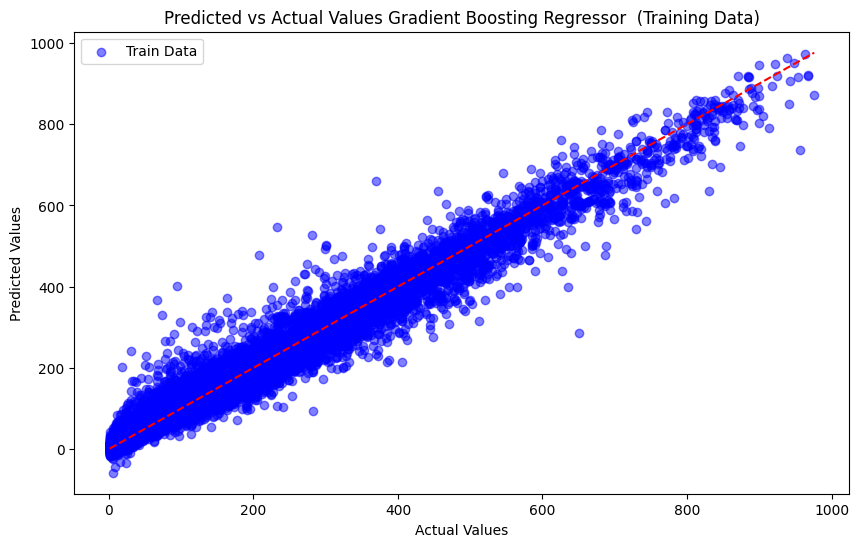

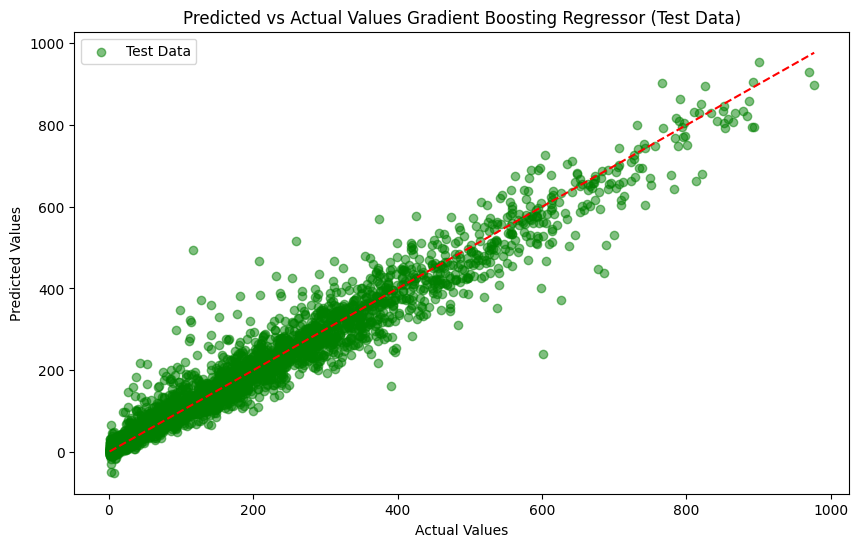

In [559]:
plt.figure(figsize=(10, 6))
plt.scatter(y_train, train_predictions, color='blue', alpha=0.5, label="Train Data")
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values Gradient Boosting Regressor  (Training Data)")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions, color='green', alpha=0.5, label="Test Data")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values Gradient Boosting Regressor (Test Data)")
plt.legend()
plt.show()

This shows we have succesfully captured the trend, as predicted values match the actual values.

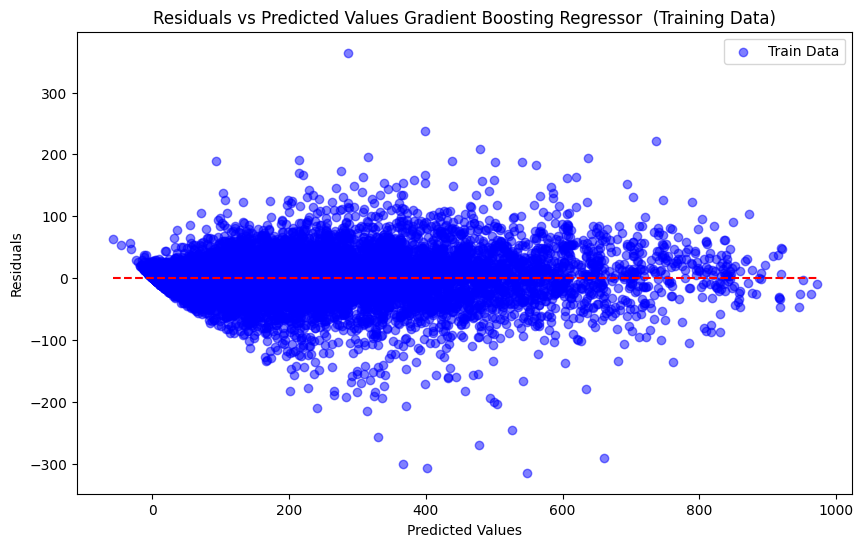

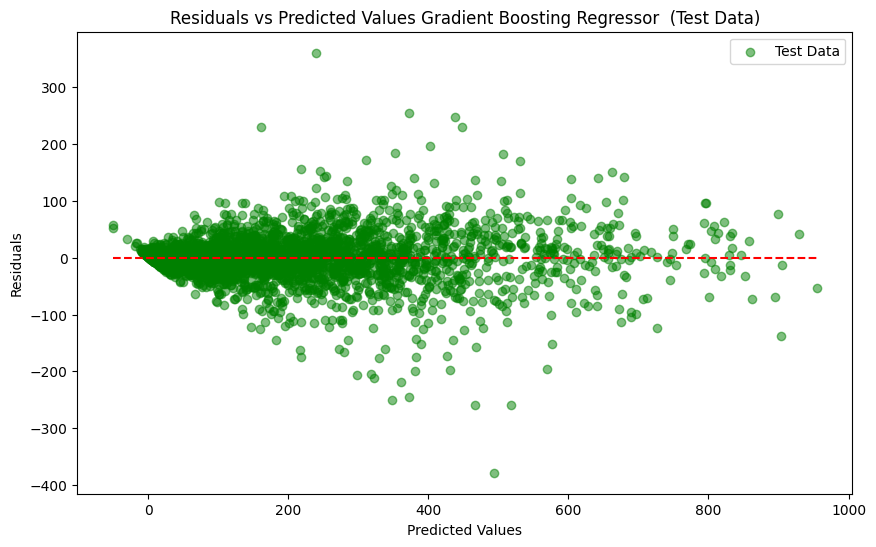

In [560]:
train_residuals = y_train - train_predictions
test_residuals = y_test - test_predictions

plt.figure(figsize=(10, 6))
plt.scatter(train_predictions, train_residuals, color='blue', alpha=0.5, label="Train Data")
plt.hlines(0, min(train_predictions), max(train_predictions), colors='red', linestyles='dashed')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values Gradient Boosting Regressor  (Training Data)")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(test_predictions, test_residuals, color='green', alpha=0.5, label="Test Data")
plt.hlines(0, min(test_predictions), max(test_predictions), colors='red', linestyles='dashed')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values Gradient Boosting Regressor  (Test Data)")
plt.legend()
plt.show()

Residuals seem to be evently distrubuted around 0 with an even spread, we will analyse thee distribution to gain more insights.

Average Training Residual: 6.525361181173099e-15
Average Test Residual: -0.24034174427485866


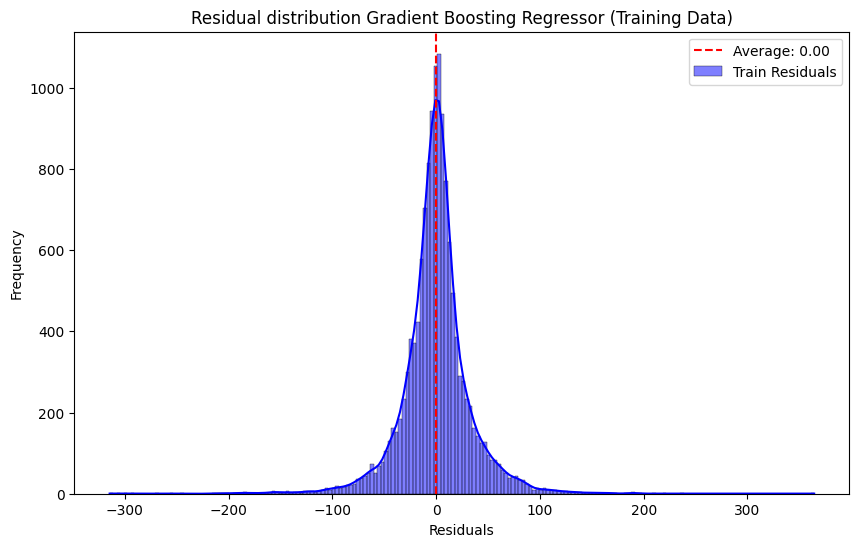

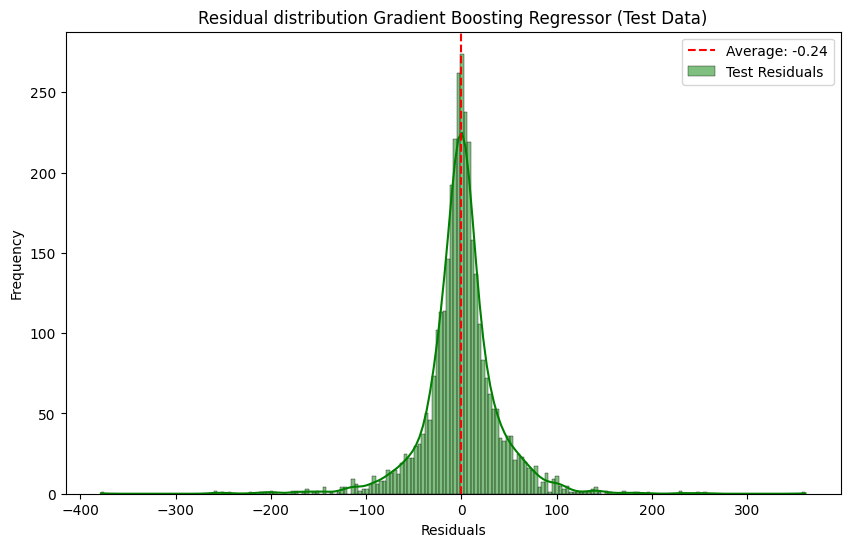

In [561]:
avg_train_residual = np.mean(train_residuals)
avg_test_residual = np.mean(test_residuals)

print(f"Average Training Residual: {avg_train_residual}")
print(f"Average Test Residual: {avg_test_residual}")

plt.figure(figsize=(10, 6))
sns.histplot(train_residuals, kde=True, color='blue', bins=200, label="Train Residuals")
plt.axvline(avg_train_residual, color='red', linestyle='--', label=f"Average: {avg_train_residual:.2f}")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual distribution Gradient Boosting Regressor (Training Data)")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(test_residuals, kde=True, color='green', bins=200, label="Test Residuals")
plt.axvline(avg_test_residual, color='red', linestyle='--', label=f"Average: {avg_test_residual:.2f}")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual distribution Gradient Boosting Regressor (Test Data)")
plt.legend()
plt.show()

Residuals follow a normal distribution, with average residuals close to 0. This means they are evenly spread around 0, with negative residuals cancelling out positive residuals.

## Extra Trees Regressor:

In [562]:
categorical_features = ['yr', 'mnth', 'weathersit']
encoder = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough',
    force_int_remainder_cols=False
)
etr = ExtraTreesRegressor(random_state=42)
param_dist_etr = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': [None, 'sqrt', 'log2']
}
random_search_etr = RandomizedSearchCV(
    estimator=etr,
    param_distributions=param_dist_etr,
    n_iter=10,
    cv=10,
    verbose=1,
    n_jobs=-1,
    random_state=42,
    scoring='neg_mean_squared_error'
)
pipeline_etr = Pipeline(steps=[
    ('encoder', encoder),
    ('random_search', random_search_etr)
])
pipeline_etr.fit(X_train, y_train)
best_model_etr = pipeline_etr.named_steps['random_search'].best_estimator_
best_params_etr = pipeline_etr.named_steps['random_search'].best_params_
best_score_etr = pipeline_etr.named_steps['random_search'].best_score_
train_predictions_etr = pipeline_etr.predict(X_train)
test_predictions_etr = pipeline_etr.predict(X_test)
mae_train_etr = mean_absolute_error(y_train, train_predictions_etr)
mse_train_etr = mean_squared_error(y_train, train_predictions_etr)
rmse_train_etr = np.sqrt(mse_train_etr)
r2_train_etr = r2_score(y_train, train_predictions_etr)
n_train = len(y_train)
p = X_train.shape[1]
adjusted_r2_train_etr = 1 - ((1 - r2_train_etr) * (n_train - 1) / (n_train - p - 1))
mae_test_etr = mean_absolute_error(y_test, test_predictions_etr)
mse_test_etr = mean_squared_error(y_test, test_predictions_etr)
rmse_test_etr = np.sqrt(mse_test_etr)
r2_test_etr = r2_score(y_test, test_predictions_etr)
n_test = len(y_test)
adjusted_r2_test_etr = 1 - ((1 - r2_test_etr) * (n_test - 1) / (n_test - p - 1))
results_dict_etr = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'R2', 'Adjusted R2'],
    'Train': [mae_train_etr, mse_train_etr, rmse_train_etr, r2_train_etr, adjusted_r2_train_etr],
    'Test': [mae_test_etr, mse_test_etr, rmse_test_etr, r2_test_etr, adjusted_r2_test_etr]
}
results_df_etr = pd.DataFrame(results_dict_etr)
print(best_params_etr)
print("\nTrain - Test metrics for Extra Trees Regressor:")
print(results_df_etr)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
{'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40}

Train - Test metrics for Extra Trees Regressor:
        Metric        Train         Test
0          MAE    22.496240    28.593880
1          MSE  1152.218807  1854.258657
2         RMSE    33.944349    43.061104
3           R2     0.965297     0.941442
4  Adjusted R2     0.965279     0.941324


Gradient Boosting Regressor has slightly better results.

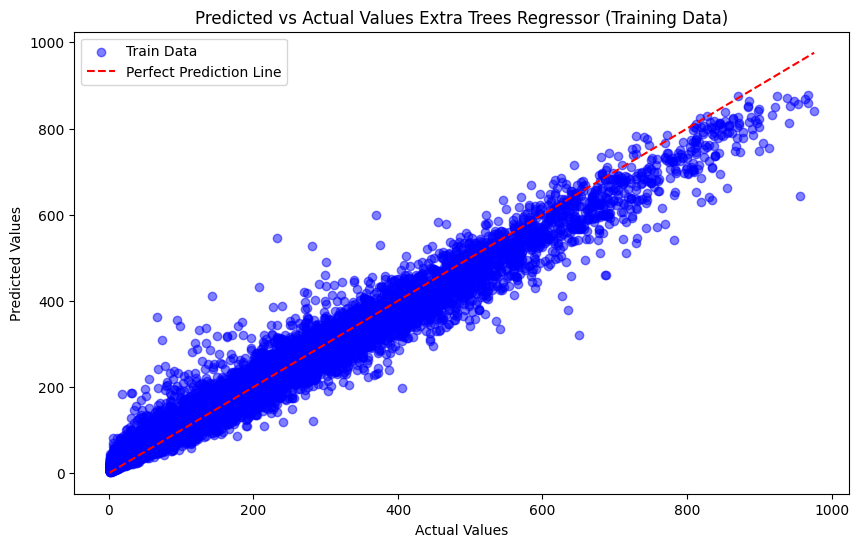

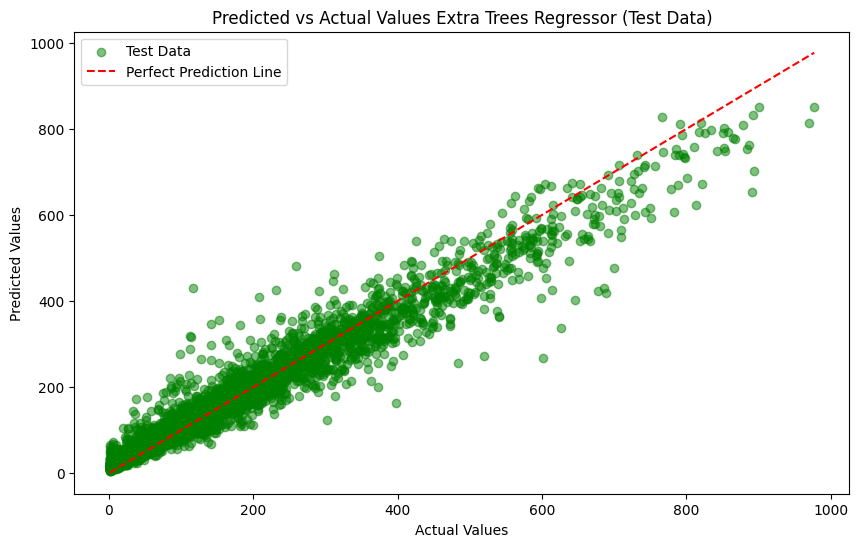

In [563]:
plt.figure(figsize=(10, 6))
plt.scatter(y_train, train_predictions_etr, color='blue', alpha=0.5, label="Train Data")
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r--', label="Perfect Prediction Line")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values Extra Trees Regressor (Training Data)")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions_etr, color='green', alpha=0.5, label="Test Data")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label="Perfect Prediction Line")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values Extra Trees Regressor (Test Data)")
plt.legend()
plt.show()

There seems to be an issue with residuals, it looks like the model is overpredicting for lower values and underpredicting for higher values.

We will have to analyse the residuals.

### Residual Analysis

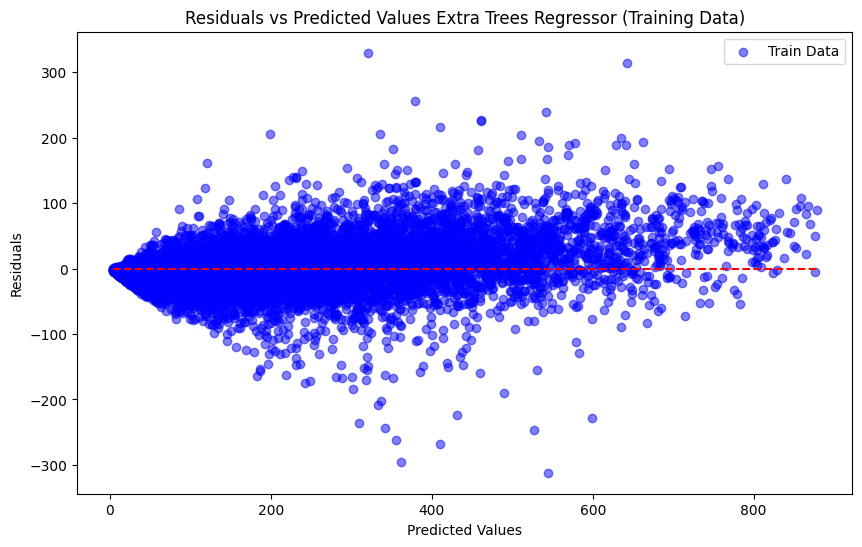

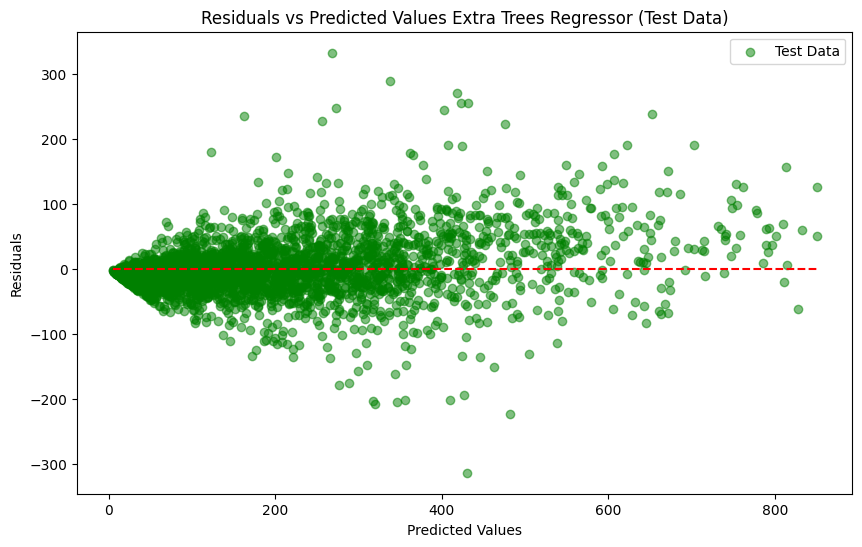

In [564]:
train_residuals = y_train - train_predictions_etr
test_residuals = y_test - test_predictions_etr

plt.figure(figsize=(10, 6))
plt.scatter(train_predictions_etr, train_residuals, color='blue', alpha=0.5, label="Train Data")
plt.hlines(0, min(train_predictions_etr), max(train_predictions_etr), colors='red', linestyles='dashed')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values Extra Trees Regressor (Training Data)")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(test_predictions_etr, test_residuals, color='green', alpha=0.5, label="Test Data")
plt.hlines(0, min(test_predictions_etr), max(test_predictions_etr), colors='red', linestyles='dashed')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values Extra Trees Regressor (Test Data)")
plt.legend()
plt.show()

As expected, there is no even distribution around 0, as there are underpredictions for higher values and overpredictions for lower values.

knowing that residuals = actual - predicted values

We will now check the residual distribution.

Average Training Residual: 1.3410516713187822e-15
Average Test Residual: -0.6553221842926573


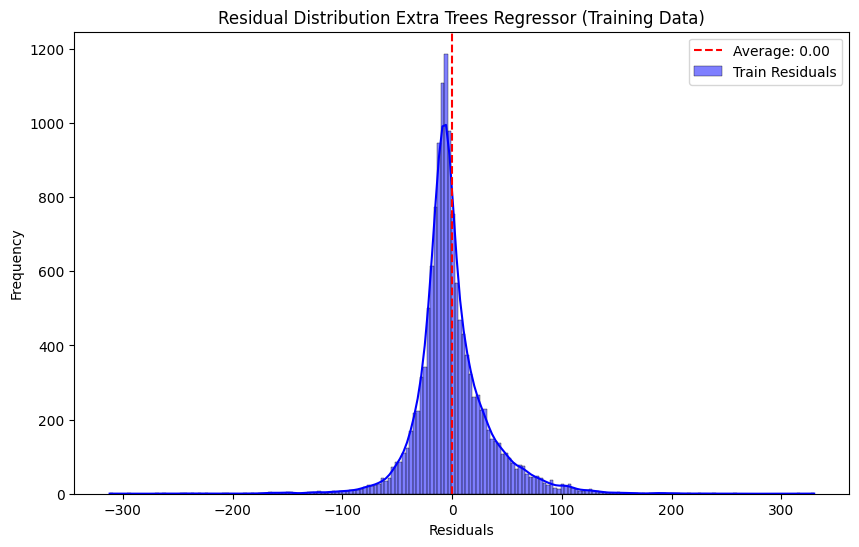

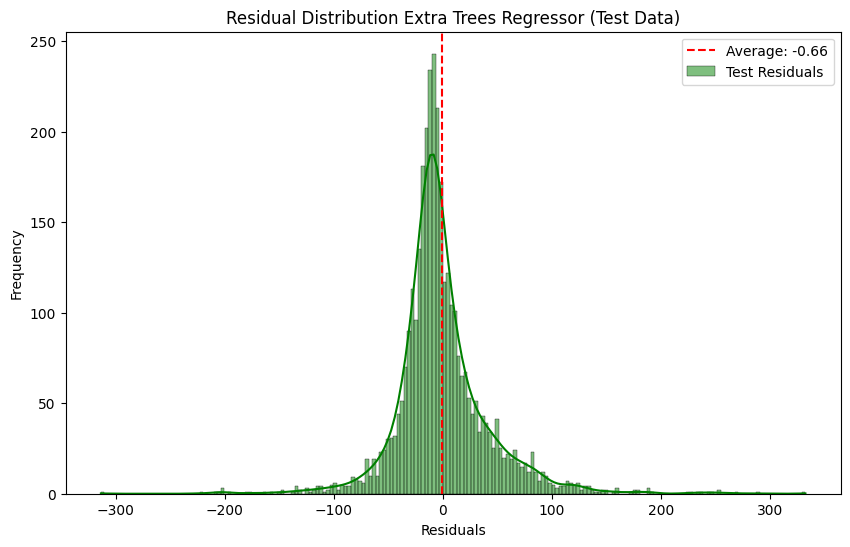

In [565]:
avg_train_residual = np.mean(train_residuals)
avg_test_residual = np.mean(test_residuals)

print(f"Average Training Residual: {avg_train_residual}")
print(f"Average Test Residual: {avg_test_residual}")

plt.figure(figsize=(10, 6))
sns.histplot(train_residuals, kde=True, color='blue', bins=200, label="Train Residuals")
plt.axvline(avg_train_residual, color='red', linestyle='--', label=f"Average: {avg_train_residual:.2f}")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Distribution Extra Trees Regressor (Training Data)")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(test_residuals, kde=True, color='green', bins=200, label="Test Residuals")
plt.axvline(avg_test_residual, color='red', linestyle='--', label=f"Average: {avg_test_residual:.2f}")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Distribution Extra Trees Regressor (Test Data)")
plt.legend()
plt.show()

This shows that our model in general is slightly biased towards overpredictions as the the distribution seems to be skewed left from the mean.

The reason why average residuals are still close to 0 is likely due to the fact that, as mentioned earlier, the model underpredicts for higher values which affects the average residuals, this can be seen on this graph as well.

## Model selection.

After considering multiple models, we found that the Gradient Boosting Regressor gave the best results.

The next step is to export the pipeline for the selected model and use it in the Streamlit webpage.

In [566]:
joblib.dump(pipeline, 'gbr_pipeline.pkl')

['gbr_pipeline.pkl']